In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import pearsonr
from scipy import stats

import joblib
from tqdm import tqdm
import os

# Preprocessing 

In [2]:
date = '25.05.13'

In [3]:
fixed = pd.read_csv('../EN00_03.28.23.csv')

#separate numerical and non-numerical data
df_cleaned_num = fixed.select_dtypes(exclude=['object'])
df_cleaned_cat = fixed.select_dtypes(include=['object'])

#dummy-code all categorical data
df_cleaned_cat = pd.get_dummies(df_cleaned_cat, dummy_na=False)
print(df_cleaned_cat.shape)

#merge back categorical and numerical variables
df_cleaned_merged = df_cleaned_num.join(df_cleaned_cat)
print(df_cleaned_merged.shape)
fixed=df_cleaned_merged
fixed_cols= list(fixed.columns)
print(len(fixed_cols))
fixed_cols.append('APOE')

#version with statins intake 
balanced_df = pd.read_csv('../apoe_fh_balanced_df_03.28.23.csv', index_col=0)
print(balanced_df.shape)

(384, 86)
(384, 184)
184
(432, 331)


In [4]:
baseline_df = balanced_df[fixed_cols].drop(columns=['APOE',
 'APOE_3 2',
 'APOE_3 3',
 'APOE_4 2',
 'APOE_4 3',
 'APOE_4 4',])

cca_cols = []
for i in range(1,51):
    cca_cols.append(f"{i}")

#keep one-hot encoded APOE genotypes
#APOE e4e4 excluded
apoe_gen = [ 'APOE_3 2',
 'APOE_3 3',
 'APOE_4 3']

balanced_df = balanced_df.drop(columns=['APOE','APOE_4 2','APOE_4 4'])

#all Prevent_AD columns
all_phens_cols = list(balanced_df.drop(columns=apoe_gen).drop(columns=cca_cols).drop(columns=['CandID','Candidate_Age_MoCA','Candidate_Age_lab']).columns)

#ALL columns (except APOE genotypes)
all_cols = all_phens_cols.copy()
for col in cca_cols:
    all_cols.append(col)
    
# Data normalization and standarization
scaler = StandardScaler()
z_df = scaler.fit_transform(balanced_df)
z_df_df = pd.DataFrame(z_df, columns = balanced_df.columns)
z_df_df['CandID'] =balanced_df['CandID']

df = balanced_df.reset_index()

# Store indices for males and females
id_f = np.where(df.Sex_Female==1)
id_m = np.where(df.Sex_Male==1)
id_all = df.index

In [5]:
def partial_least_square(df, x_cols, y_cols,comp,plot,tag):

    """
    Fit a PLS regression model and optionally plot Y loadings.

    Parameters:
    - df: pandas.DataFrame, the input data.
    - x_cols: list of str, predictor column names.
    - y_cols: list of str, response column names.
    - n_components: int, number of PLS components.
    - plot: bool, whether to plot the Y loadings.
    - tag: str, used for plot titles and filenames.

    Returns:
    - fitted PLSRegression object.
    """
   
    pls = PLSRegression(n_components=comp)
    pls.fit(df[x_cols],df[y_cols])
    if plot:

        figure(figsize=(4, 4), dpi=200)
        sns.heatmap(
            pls.y_loadings_[:, :3],
            cmap=plt.cm.RdBu_r,
            center=0,
            vmin=-0.4, vmax=0.4,
            square=True,
            annot=True,
            yticklabels=[r'$\mathit{APOE}\ \epsilon$3/2',
                         r'$\mathit{APOE}\ \epsilon$3/3',
                         r'$\mathit{APOE}\ \epsilon$3/4'],
            xticklabels=[f'Comp {i+1}' for i in range(3)],
            cbar_kws={"shrink": 0.4}
        )
        plt.title(f'Y loadings for PLS-R on {tag}')
        plt.xlabel('PLS-R components')
        plt.subplots_adjust(top=1)
        output_path = f'{date}/{tag}_pls_y_loadings_all_time_points_.png'
        plt.savefig(output_path, dpi=200, bbox_inches='tight')
        plt.show()
        plt.close('all')
    
    return pls

In [6]:
def pls_loadings(dff, idx, tag):

    """
    Fit PLS on input data and return transformed latent components with time info.

    Parameters:
    - dff: DataFrame, data to be used for PLS fitting.
    - idx: list-like, indices corresponding to rows in `balanced_df` for time labels.
    - tag: str, label for saving plots and file outputs.
    - n_components: int, number of PLS components to extract.
    - plot: bool, whether to generate and save loading plots.

    Returns:
    - latent_factors_df: DataFrame with latent components and 'time' column.
    - pls_model: Trained PLSRegression object.
    """
    
    pls = partial_least_square(dff, all_phens_cols,apoe_gen,comp=3, plot=True, tag=tag)
    latent_factors_pls = pls.transform(dff[all_phens_cols])
    latent_factors_pls_df = pd.DataFrame(latent_factors_pls, columns=['C1', 'C2', 'C3'])
    latent_factors_pls_df['time'] = list(balanced_df.iloc[idx].time_diff)
    
    return latent_factors_pls_df,pls


In [7]:
# columns to remove from pls to keep for regression model or later steps
cols_reg =  ['Sex_Female',
             'Sex_Male', 
             'father_dx_ad_dementia',
             'mother_dx_ad_dementia',
             'sibling_dx_ad_dementia',
             'time_diff',
             'Age_baseline_months']

# Subsetting by sex and parental AD lineage
id_mat = np.where(z_df_df.only_mother>0)
df_mat = z_df_df.iloc[id_mat]

id_pat = np.where(z_df_df.only_father>0)
df_pat = z_df_df.iloc[id_pat]

id_males = np.where(z_df_df.Sex_Male>0)
df_males = z_df_df.iloc[id_males]

id_females = np.where(z_df_df.Sex_Female>0)
df_females = z_df_df.iloc[id_females]

In [8]:
all_phens_cols = list(balanced_df.drop(columns=apoe_gen).drop(columns=cca_cols).drop(columns=[
    'CandID',
    'Candidate_Age_MoCA',
    'Candidate_Age_lab',
    'RBANS_version_A',
    'RBANS_version_B',
    'RBANS_version_C',
    'RBANS_version_D',
    'comments',
    'only_father',
    'only_mother',
    'both']).drop(columns=cols_reg).columns)

In [9]:
# Load phenotype category information from CSV
cat_df = pd.read_csv('../cat_May_25.csv', index_col=0)

# Create a dictionary mapping original phenotype names to their broader category
cat_dict = {}
for i in range(0, len(cat_df)):
    cat_dict[cat_df.phens[i]] = cat_df.cat[i]

# Generate a list of category labels corresponding to each phenotype in all_phens_cols
cat = []
for phens in all_phens_cols:
    v_cat = cat_dict[phens]
    cat.append(v_cat)

# Create a dictionary mapping original phenotype names to their cleaned or renamed versions
names_dict = {}
for i in range(0, len(cat_df)):
    names_dict[cat_df.phens[i]] = cat_df.new_names[i]


In [10]:
# Compute summary statistics (mean, max, min, std)
means = np.round(df[all_phens_cols].mean(),3)
maxx = df[all_phens_cols].max()
minn = df[all_phens_cols].min()
std = np.round(df[all_phens_cols].std(),3)

# Create a DataFrame summarizing statistics for each phenotype
summary_df = pd.DataFrame({
    'phenotypes': all_phens_cols,
    'mean': means,
    'max': maxx,
    'min': minn,
    'sd': std
})

# Set phenotype names as index
summary_df = summary_df.set_index('phenotypes', drop=False)

# Rename phenotype index labels using category and name dictionaries
summary_df = summary_df.rename(index=cat_dict)
summary_df = summary_df.rename(index=names_dict)

# Add category labels as a column based on the updated index
summary_df['cat'] = summary_df.index

# Rename 'phenotypes' column to 'codes' and set it as the index
summary_df = summary_df.rename(columns={'phenotypes': 'codes'})
summary_df = summary_df.set_index('codes', drop=False)

# Save to CSV
summary_df = summary_df.reset_index(drop=True)
summary_df.to_csv('summary_stats.csv')


# PLS on whole population

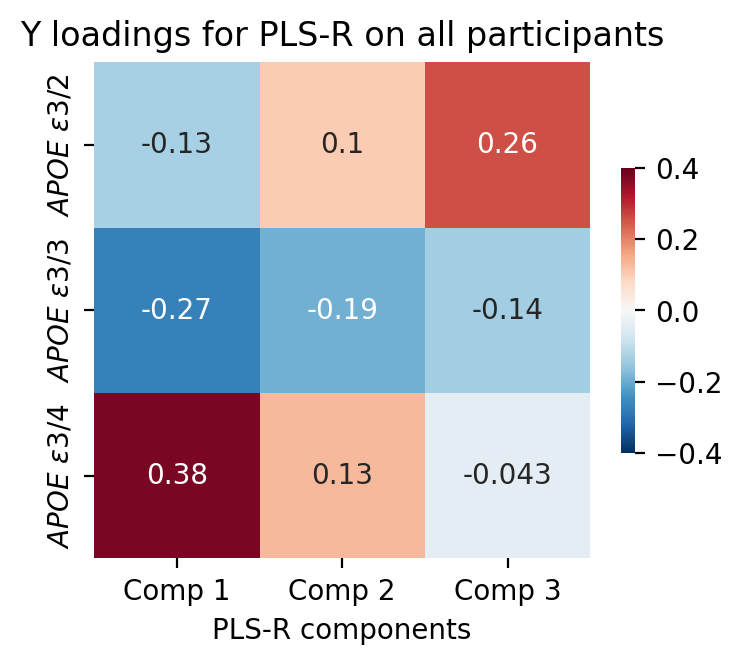

In [11]:
loadings_df, og_pls = pls_loadings(z_df_df,z_df_df.index, 'all participants')

Component-wise Pearson correlations: [0.76047328 0.56657989 0.58381115]


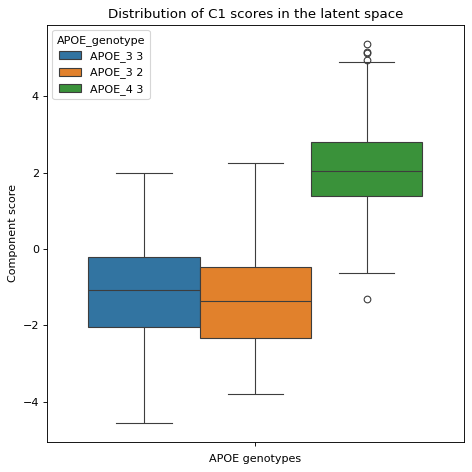

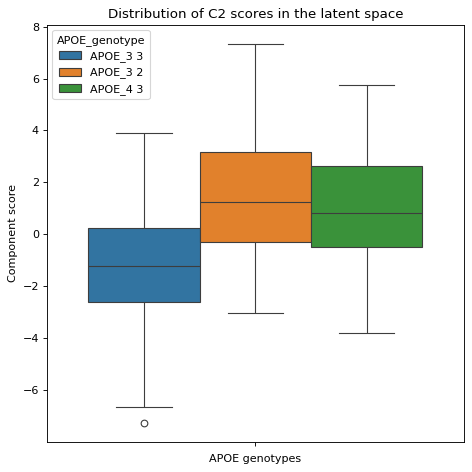

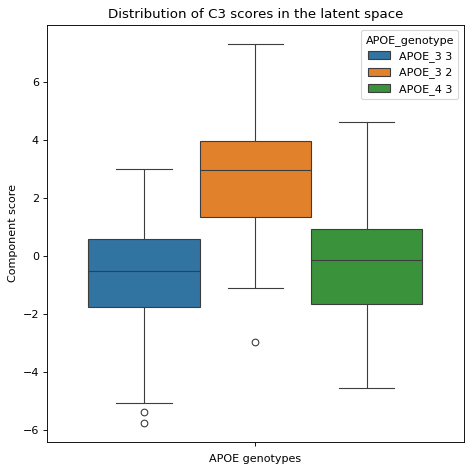

In [12]:
# Compute actual Pearson correlations between latent X and Y scores
est = og_pls
actual_Rs = np.array([
    pearsonr(x, y)[0] for x, y in zip(est.x_scores_.T, est.y_scores_.T)
])
print("Component-wise Pearson correlations:", actual_Rs)

# Create DataFrames for latent scores
components = ['C1', 'C2', 'C3']
x_loadings = pd.DataFrame(est.x_scores_, columns=components)
y_loadings = pd.DataFrame(est.y_scores_, columns=components)  # Optional if not used

# Combine APOE genotype and component scores
to_plot = pd.concat([df[apoe_gen], x_loadings], axis=1)

# Determine APOE genotype label
def determine_apoe(row):
    for genotype in ['APOE_3 2', 'APOE_3 3', 'APOE_4 3']:
        if row.get(genotype, 0) == 1:
            return genotype
    return 'Unknown'

to_plot['APOE_genotype'] = to_plot.apply(determine_apoe, axis=1)

# Plotting function
def plot_component_boxplot(component):
    plt.figure(figsize=(6, 6), dpi=80)
    sns.boxplot(data=to_plot, y=component, hue='APOE_genotype')
    plt.title(f'Distribution of {component} scores in the latent space')
    plt.ylabel('Component score')
    plt.xlabel('APOE genotypes')
    plt.savefig(f'{date}/{component}_scores', dpi=200, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

# Plot all three components
for comp in components:
    plot_component_boxplot(comp)


[[-0.13260767]
 [-0.26887559]
 [ 0.37959435]]


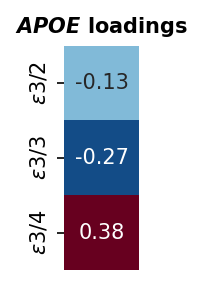

[[ 0.10008721]
 [-0.19369154]
 [ 0.12815011]]


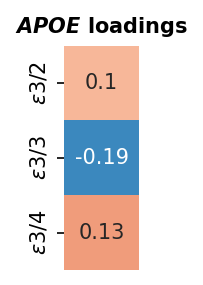

[[ 0.25640482]
 [-0.14060361]
 [-0.04346157]]


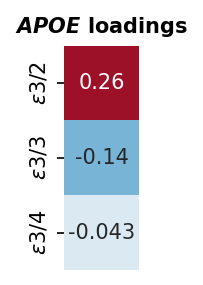

In [13]:
# APOE genotype labels
yticklabels = [r'$\epsilon$3/2', r'$\epsilon$3/3', r'$\epsilon$3/4']
vmin, vmax = -0.3, 0.3
cmap = plt.cm.RdBu_r

# Loop over PLS-R components
for i in range(3):
    fig, ax = plt.subplots(figsize=(1, 2), dpi=150)
    
    # Extract loadings for component i
    component_loadings = og_pls.y_loadings_[:, i:i+1]
    print(component_loadings)
    
    # Create heatmap
    sns.heatmap(
        component_loadings,
        cmap=cmap,
        center=0,
        square=True,
        annot=True,
        vmin=vmin,
        vmax=vmax,
        yticklabels=yticklabels,
        xticklabels=[],
        cbar=False,
        ax=ax
    )
    
    # Title and layout
    ax.set_title(
        r"$\mathbfit{APOE}$ loadings",
        fontweight='bold',
        fontsize=10
    )
    
    plt.tight_layout()
    plt.savefig(
        f'{date}/IP{i+1}_pls_y_loadings.png',
        dpi=200,
        bbox_inches='tight'
    )
    plt.show()


## Boostrapping test

In [14]:
def partial_least_square(df, x_cols, y_cols, n_components, plot=True, tag=""):
    """
    Fit a PLSRegression model and optionally plot X and Y loadings.

    Parameters:
    df : pd.DataFrame
        Input data containing X and Y variables.
    x_cols : list
        Column names for predictors.
    y_cols : list
        Column names for response variables.
    n_components : int
        Number of PLS components.
    plot : bool, optional
        Whether to plot heatmaps of loadings.
    tag : str, optional
        Identifier used in plot titles and filenames.

    Returns:
    pls : sklearn.cross_decomposition.PLSRegression
        The fitted PLSRegression model.
    """

    pls = PLSRegression(n_components=n_components)
    pls.fit(df[x_cols], df[y_cols])

    if plot:
        tag_clean = tag.replace(' ', '_')
        component_labels = [f'C{i+1}' for i in range(n_components)]

        # Plot X loadings
        plt.figure(figsize=(3, len(x_cols) * 0.3), dpi=100)
        sns.heatmap(
            pls.x_loadings_[:, :n_components],
            cmap=plt.cm.RdBu_r,
            center=0,
            yticklabels=x_cols,
            xticklabels=component_labels,
            square=False
        )
        plt.title(f'X loadings for PLS-R on {tag}')
        plt.xlabel('PLS-R components')
        plt.tight_layout()
        plt.savefig(f'{date}/{tag_clean}_pls_x_loadings_all_time_points_.png', dpi=200, bbox_inches='tight')
        plt.show()

        # Plot Y loadings
        plt.figure(figsize=(3, len(y_cols) * 0.3), dpi=100)
        sns.heatmap(
            pls.y_loadings_[:, :n_components],
            cmap=plt.cm.RdBu_r,
            center=0,
            yticklabels=y_cols,
            xticklabels=component_labels,
            square=False
        )
        plt.title(f'Y loadings for PLS-R on {tag}')
        plt.xlabel('PLS-R components')
        plt.tight_layout()
        plt.savefig(f'{date}/{tag_clean}_pls_y_loadings_all_time_points_.png', dpi=200, bbox_inches='tight')
        plt.show()

   # Calculate Pearson correlation for each component pair
    actual_Rs = np.array([
        pearsonr(X_comp, Y_comp)[0]
        for X_comp, Y_comp in zip(pls.x_scores_.T, pls.y_scores_.T)
    ])
    #print(f'Component correlations (X ↔ Y): {actual_Rs.round(3)}')

    return pls

In [15]:
def match_comps(pls_1, pls_2, n, n_return=False):

    """
    Aligns and matches the components between two PLSRegression models.

    This function compares the Y-loadings of two PLS models (typically an original model and a bootstrapped one),
    and reorders and sign-corrects the components of the second model (pls_2) to best align with those of the first model (pls_1).

    Steps:
    - Computes the correlation between each component of pls_1 and pls_2 using Y-loadings.
    - For each component in pls_1, identifies the best-matching component in pls_2 (based on absolute Pearson correlation).
    - Ensures each component is matched only once (avoids duplicates).
    - Corrects for sign flips (if correlation is negative).
    - Returns the aligned X-loadings for both models as DataFrames, using `all_phens_cols` as the feature index.

    Parameters
    ----------
    pls_1 : sklearn.cross_decomposition.PLSRegression
        The reference PLS model to match components to.
    pls_2 : sklearn.cross_decomposition.PLSRegression
        The PLS model to be aligned (typically from a bootstrap iteration).

    Returns
    -------
    pls_1_cat : pandas.DataFrame
        X-loadings from the original model.
    pls_2_cat : pandas.DataFrame
        X-loadings from the aligned second model, reordered and sign-corrected.
    """
    
    # Creating a flag value in case the component is flipped by -1
    flag = []
    # Computing the Pearson's correlation matrix on the entire set of PLS loadings
    corr_mat = np.corrcoef(pls_1.y_loadings_.T,pls_2.y_loadings_.T)
    corr_mat = corr_mat[:n,n:]

    # Consider all components into the matching process
    n_keep = n
    taken_ind=[]

    # Find best-matching component pairs
    for i_org_comp in range(n_keep):
            rhos = np.zeros((n_keep))
            for i_comp in range(n_keep):
                rhos[i_comp], _ = pearsonr(
                    pls_1.y_loadings_[:,i_org_comp],
                    pls_2.y_loadings_[:,i_comp])
            good_comp_ind = np.argmax(abs(rhos))
            i = 1
            while good_comp_ind in taken_ind:
                sorted_rhos = (-(abs(rhos))).argsort()
                good_comp_ind = sorted_rhos[i]
                i +=1
            taken_ind.append(good_comp_ind)
            # print(f'component {i_org_comp} in pls_1 is {good_comp_ind} in pls_2 with {rhos[good_comp_ind]}')
            
            # Handle sign-flipping
            if rhos[good_comp_ind]<0:
                flag.append(-1)
            else:
                flag.append(1)

    if n_return:
         n_keep = n_return
    else:
         n_keep = n 
    
    # Reorder and sign-correct pls_2 components
    pls_2_ind = taken_ind
    pls_2_y_loadings = pls_2.y_loadings_[:,pls_2_ind]
    pls_2_x_loadings = pls_2.x_loadings_[:,pls_2_ind]
    for i in range(len(flag)):
        pls_2_y_loadings[:,i] = flag[i] * pls_2_y_loadings[:,i]
        pls_2_x_loadings[:,i] = flag[i] * pls_2_x_loadings[:,i]
    
    # Return matched and aligned X-loadings as pandas DataFrames
    pls_1_cat = pd.DataFrame(pls_1.x_loadings_[:,0:n_keep], index=all_phens_cols)
    pls_2_cat = pd.DataFrame(pls_2_x_loadings[:,0:n_keep], index=all_phens_cols)
  
    return pls_1_cat, pls_2_cat

In [16]:
print(date)

25.05.13


In [17]:
n_comp = 10
n_it = 1000

# Fit PLS on original data
og_pls = partial_least_square(z_df_df, all_phens_cols, apoe_gen, n_comp, plot=False, tag=f'og')
og_loadings = pd.DataFrame(og_pls.x_loadings_, index=all_phens_cols)

# Bootstrapping loop
for i in tqdm(range(0,n_it), desc="Bootstrapping"):
    rand_df = sklearn.utils.resample(z_df_df, replace=True, random_state=i).reset_index(drop=True)
    rand_pls = partial_least_square(rand_df, all_phens_cols, apoe_gen, n_comp, plot=False, tag=f'it_{i}')
    joblib.dump(rand_pls,f'{date}/bts/it_{i}')

# Store loadings for each iteration
bts_df = pd.DataFrame()
for i in tqdm(range(0,n_it),desc="Aligning components"):
    rand_pls = joblib.load(f'{date}/bts/it_{i}')
    pls_1, pls_2 = match_comps(og_pls, rand_pls, n_comp)
    pls_2.columns = [f'{j}_it_{i}' for j in range(1, n_comp+1)]
    bts_df = pd.concat([bts_df,pls_2],axis=1)

# Compute the correlation between the boostrap loadings and original loadings
for i in range(0,n_comp):
    comp = bts_df.iloc[:,i::n_comp]
    coef = np.corrcoef(og_loadings.iloc[:,i],comp.mean(axis=1))[0][1]
    print(f'Component {i+1}: {abs(np.round(coef,3))}')

Aligning components: 100%|██████████| 1000/1000 [01:47<00:00,  9.28it/s]


Component 1: 0.988
Component 2: 0.793
Component 3: 0.778
Component 4: 0.453
Component 5: 0.064
Component 6: 0.038
Component 7: 0.094
Component 8: 0.19
Component 9: 0.281
Component 10: 0.104


In [18]:
# Compute the correlation between the boostrap loadings and original loadings
# Store p-values
coefs = []
pvals = []
for i in range(0,n_comp):
    comp = bts_df.iloc[:,i::n_comp]
    coef, pval = stats.pearsonr(og_loadings.iloc[:,i],comp.mean(axis=1))
    print(f'Component {i+1}: {abs(np.round(coef,3))}, {np.round(pval,5)}')
    coefs.append(abs(coef))
    pvals.append(pval)

Component 1: 0.988, 0.0
Component 2: 0.793, 0.0
Component 3: 0.778, 0.0
Component 4: 0.453, 0.0
Component 5: 0.064, 0.3041
Component 6: 0.038, 0.54058
Component 7: 0.094, 0.13367
Component 8: 0.19, 0.00223
Component 9: 0.281, 0.0
Component 10: 0.104, 0.09508


/var/folders/pr/cb_pqkw930d_pggjvtvfzl3w0000gn/T/ipykernel_10099/3785283768.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


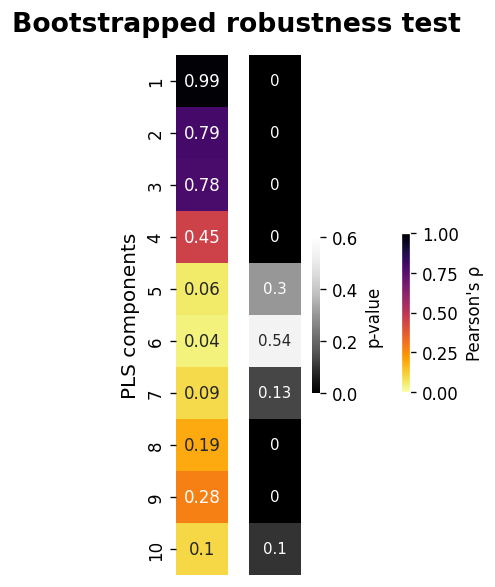

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(2.5, 5),dpi=120)

# Plot the first heatmap
heatmap1 = sns.heatmap(np.round(np.array(coefs).reshape(-1,1),2),
            square=True, cmap='inferno_r', xticklabels=[],vmin=0,vmax=1,
            yticklabels=range(1,11), annot=True, cbar_kws={"shrink": 0.5, 'label':"Pearson's ρ"},
            ax=axs[0], cbar=False)
axs[0].set_ylabel('PLS components', fontsize=12)
cbar_ax1 = fig.add_axes([1, 0.335, 0.03, 0.265])  # [left, bottom, width, height]
cbar1 = fig.colorbar(heatmap1.get_children()[0], cax=cbar_ax1, label="Pearson's ρ",pad=0.5)
cbar1.outline.set_edgecolor('white')

# Plot the second heatmap
sns.heatmap(np.round(np.array(pvals).reshape(-1,1),2), square=True, xticklabels=[],
            yticklabels=[], vmin=0, vmax=0.6, cmap='Greys_r', annot=True,annot_kws={"fontsize":9},
            cbar_kws={"shrink": 0.3, "pad": 0.1, "label":'p-value'},
            ax=axs[1])
plt.suptitle('Bootstrapped robustness test',fontweight='bold',fontsize=16, y=0.97, x=0.45)
plt.tight_layout()
plt.show()
plt.close('all')

# PLS models seggregated by sex and family history

In [20]:
def pls_loadings(df,tag):
    
    pls = partial_least_square(df, all_phens_cols,apoe_gen,5,plot=False,tag=tag)
    
    cat_df = pd.DataFrame(pls.x_loadings_, index=all_phens_cols)
    cat_df['cat'] = cat
    
    return pls

In [21]:
print(len(all_phens_cols))

257


## Matching the components

In [22]:
def match_comps(pls_1, pls_2, n, n_return=False):

    """
    Aligns and matches the components between two PLSRegression models.

    This function compares the Y-loadings of two PLS models (typically an original model and a bootstrapped one),
    and reorders and sign-corrects the components of the second model (pls_2) to best align with those of the first model (pls_1).

    Steps:
    - Computes the correlation between each component of pls_1 and pls_2 using Y-loadings.
    - For each component in pls_1, identifies the best-matching component in pls_2 (based on absolute Pearson correlation).
    - Ensures each component is matched only once (avoids duplicates).
    - Corrects for sign flips (if correlation is negative).
    - Returns the aligned X-loadings for both models as DataFrames, using `all_phens_cols` as the feature index.

    Parameters
    ----------
    pls_1 : sklearn.cross_decomposition.PLSRegression
        The reference PLS model to match components to.
    pls_2 : sklearn.cross_decomposition.PLSRegression
        The PLS model to be aligned (typically from a bootstrap iteration).

    Returns
    -------
    pls_1_cat : pandas.DataFrame
        X-loadings from the original model.
    pls_2_cat : pandas.DataFrame
        X-loadings from the aligned second model, reordered and sign-corrected.
    """
    
    # Creating a flag value in case the component is flipped by -1
    flag = []
    # Computing the Pearson's correlation matrix on the entire set of PLS loadings
    corr_mat = np.corrcoef(pls_1.y_loadings_.T,pls_2.y_loadings_.T)
    corr_mat = corr_mat[:n,n:]

    # Consider all components into the matching process
    n_keep = n
    taken_ind=[]

    # Find best-matching component pairs
    for i_org_comp in range(n_keep):
            rhos = np.zeros((n_keep))
            for i_comp in range(n_keep):
                rhos[i_comp], _ = pearsonr(
                    pls_1.y_loadings_[:,i_org_comp],
                    pls_2.y_loadings_[:,i_comp])
            good_comp_ind = np.argmax(abs(rhos))
            i = 1
            while good_comp_ind in taken_ind:
                sorted_rhos = (-(abs(rhos))).argsort()
                good_comp_ind = sorted_rhos[i]
                i +=1
            taken_ind.append(good_comp_ind)
            # print(f'component {i_org_comp} in pls_1 is {good_comp_ind} in pls_2 with {rhos[good_comp_ind]}')
            
            # Handle sign-flipping
            if rhos[good_comp_ind]<0:
                flag.append(-1)
            else:
                flag.append(1)

    if n_return:
         n_keep = n_return
    else:
         n_keep = n 
    
    # Reorder and sign-correct pls_2 components
    pls_2_ind = taken_ind
    pls_2_y_loadings = pls_2.y_loadings_[:,pls_2_ind]
    pls_2_x_loadings = pls_2.x_loadings_[:,pls_2_ind]
    for i in range(len(flag)):
        pls_2_y_loadings[:,i] = flag[i] * pls_2_y_loadings[:,i]
        pls_2_x_loadings[:,i] = flag[i] * pls_2_x_loadings[:,i]
    
    # Return matched and aligned X-loadings as pandas DataFrames
    # pls_1_cat = pd.DataFrame(pls_1.x_loadings_[:,0:n_keep], index=all_phens_cols)
    pls_2_cat = pd.DataFrame(pls_2_x_loadings[:,0:n_keep], index=all_phens_cols)
  
    return pls_2_cat

### Bootstrap robustness test

In [23]:
def compute_stats(group1, group2, n1=1000, n2=1000):
    """
    Compute summary statistics (means, standard deviations, t-test, Cohen's d)
    between two matched groups of samples.

    Parameters:
    - group1, group2: DataFrames with the same index and shape (variables x samples)
    - n1, n2: Sample sizes for group1 and group2 (default: 1000 each)

    Returns:
    - DataFrame summarizing means, standard deviations, t-statistics, p-values, and Cohen's d
    """

    # Compute row-wise means
    mean1 = group1.mean(axis=1)
    mean2 = group2.mean(axis=1)

    # Compute row-wise standard deviations
    std1 = group1.std(axis=1)  # sample std by default (ddof=1)
    std2 = group2.std(axis=1)

    # Compute pooled standard deviation
    sd_pooled = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))

    # Compute Cohen's d
    cohens_d = (mean1 - mean2) / sd_pooled

    # Perform paired t-test (assuming group1 and group2 are matched samples)
    t_stat, p_val = stats.ttest_rel(group1.T, group2.T)

    # Construct summary DataFrame
    summary = pd.DataFrame({
        'mean 1': mean1,
        'std 1': std1,
        'mean 2': mean2,
        'std 2': std2,
        't_stats': t_stat,
        't_stats_abs': abs(t_stat),
        'p_value': p_val,
        "Cohen's d": cohens_d
    })

    return summary


In [24]:
def overlap(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

In [25]:
og_pls = partial_least_square(z_df_df, all_phens_cols,apoe_gen,5, plot=False, tag='All participants')

In [26]:
print(og_pls.y_loadings_)

[[-0.13260767  0.10008721  0.25640482 -0.1093376   0.16418046]
 [-0.26887559 -0.19369154 -0.14060361 -0.11522485 -0.13357601]
 [ 0.37959435  0.12815011 -0.04346157  0.20167614  0.01769479]]


In [27]:
# Bootstrap analysis to assess the stability of PLS loadings in two subgroups:
# individuals with maternal history (mat) and paternal history (pat) of ADRD.

# Create empty DataFrames to store the loadings
bts_mat = pd.DataFrame()
bts_pat = pd.DataFrame()

for i in tqdm(range(0,1000), desc='Bootstrapping'):

    # Bootstrap resampling of each group (sampling individuals with replacement)
    rand_mat = sklearn.utils.resample(df_mat, replace=True, random_state=i).reset_index(drop=True)
    rand_pat = sklearn.utils.resample(df_pat, replace=True, random_state=i).reset_index(drop=True)

    # Run PLS and extract latent components for each bootstrap sample
    pls_mat = pls_loadings(rand_mat,'individuals with maternal history of ADRD')
    pls_pat = pls_loadings(rand_pat,'individuals with paternal history of ADRD')

    # Match components across the two bootstrap PLS models
    # Consider the top 5 components when doing the matching but only return the top 3 
    x_loadings_mat = match_comps(og_pls, pls_mat, 5, 3)
    x_loadings_pat = match_comps(og_pls, pls_pat, 5, 3)

    # Label the columns by iteration and component number
    cols = [f'it_{i}_comp_{j}' for j in range(1, 4)]
    x_loadings_mat.columns = cols
    x_loadings_pat.columns = cols

    # Concatenate the results to build the full bootstrapped loading matrices
    bts_mat = pd.concat([bts_mat,x_loadings_mat], axis=1)
    bts_pat = pd.concat([bts_pat,x_loadings_pat],axis=1)

# Extract the bootstrapped loadings for component 1 across all iterations
comp_1_mat = bts_mat.iloc[:,::3]
comp_1_pat = bts_pat.iloc[:,::3]

# Extract the bootstrapped loadings for component 2 across all iterations
comp_2_mat = bts_mat.iloc[:,1::3]
comp_2_pat = bts_pat.iloc[:,1::3]

# Extract the bootstrapped loadings for component 3 across all iterations
comp_3_mat = bts_mat.iloc[:,2::3]
comp_3_pat = bts_pat.iloc[:,2::3]


Bootstrapping: 100%|██████████| 1000/1000 [02:23<00:00,  6.98it/s]


In [28]:
# Bootstrap analysis to assess the stability of PLS loadings in two subgroups:
# females and males.

# Create empty DataFrames to store the loadings
bts_fem = pd.DataFrame()
bts_mal = pd.DataFrame()

for i in tqdm(range(0,1000)):

    # Bootstrap resampling of each group (sampling individuals with replacement)
    rand_fem = sklearn.utils.resample(df_females, replace=True, random_state=i).reset_index(drop=True)
    rand_mal = sklearn.utils.resample(df_males, replace=True, random_state=i).reset_index(drop=True)

    # Run PLS and extract latent components for each bootstrap sample
    pls_fem = pls_loadings(rand_fem,'females')
    pls_mal = pls_loadings(rand_mal,'males')

    # Match components across the two bootstrap PLS models
    # Consider the top 5 components when doing the matching but only return the top 3 
    x_loadings_fem = match_comps(og_pls, pls_fem, 5, 3)
    x_loadings_mal = match_comps(og_pls, pls_mal, 5, 3)

    # Label the columns by iteration and component number
    cols = [f'it_{i}_comp_{j}' for j in range(1, 4)]
    x_loadings_fem.columns = cols
    x_loadings_mal.columns = cols

    # Concatenate the results to build the full bootstrapped loading matrices
    bts_fem = pd.concat([bts_fem,x_loadings_fem], axis=1)
    bts_mal = pd.concat([bts_mal,x_loadings_mal],axis=1)

# Extract the bootstrapped loadings for component 1 across all iterations (every 3rd column starting at 0)
comp_1_fem = bts_fem.iloc[:,::3]
comp_1_mal = bts_mal.iloc[:,::3]

# Extract the bootstrapped loadings for component 2 across all iterations (every 3rd column starting at 0)
comp_2_fem = bts_fem.iloc[:,1::3]
comp_2_mal = bts_mal.iloc[:,1::3]

# Extract the bootstrapped loadings for component 3 across all iterations (every 3rd column starting at 0)
comp_3_fem = bts_fem.iloc[:,2::3]
comp_3_mal = bts_mal.iloc[:,2::3]

 97%|█████████▋| 968/1000 [02:25<00:05,  5.70it/s]/Users/chloesavignac/.conda/envs/masters_projects/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
100%|██████████| 1000/1000 [02:31<00:00,  6.61it/s]


Intermediate phenotype 1

In [29]:
comp1_results_fem_mal = compute_stats(comp_1_fem, comp_1_mal)
print('Sex: ' + str(len(comp1_results_fem_mal.loc[comp1_results_fem_mal.p_value>0.05])))
comp1_results_fem_mal.rename(index=names_dict).to_csv('Supplementary_Table_1.csv')

comp1_results_mat_pat = compute_stats(comp_1_mat, comp_1_pat)
print('Lineage: ' + str(len(comp1_results_mat_pat.loc[comp1_results_mat_pat.p_value>0.05])))
comp1_results_mat_pat.rename(index=names_dict).to_csv('Supplementary_Table_2.csv')

# Number of risk indicators that show neither lineage nor sex biases
print(len(overlap(list(comp1_results_fem_mal.loc[comp1_results_fem_mal.p_value>0.05].index),
    list(comp1_results_mat_pat.loc[comp1_results_mat_pat.p_value>0.05].index))))
# Print risk indicators that show neither lineage nor sex biases
print(overlap(list(comp1_results_fem_mal.loc[comp1_results_fem_mal.p_value>0.05].index),
    list(comp1_results_mat_pat.loc[comp1_results_mat_pat.p_value>0.05].index)))

Sex: 27
Lineage: 27
4
['figure_recall_drawing_score', 'UPSIT_total_score', 'LDL_value_baseline', 'Work_by_category_Sales']


Intermediate phenotype 2

In [30]:
comp2_results_fem_mal = compute_stats(comp_2_fem, comp_2_mal)
print('Sex: ' + str(len(comp2_results_fem_mal.loc[comp2_results_fem_mal.p_value>0.05])))
comp2_results_fem_mal.rename(index=names_dict).to_csv('Supplementary_Table_3.csv')

comp2_results_mat_pat = compute_stats(comp_2_mat, comp_2_pat)
print('Lineage: ' + str(len(comp2_results_mat_pat.loc[comp2_results_mat_pat.p_value>0.05])))
comp2_results_mat_pat.rename(index=names_dict).to_csv('Supplementary_Table_4.csv')

# Number of risk indicators that show neither lineage nor sex biases
print(len(overlap(list(comp2_results_fem_mal.loc[comp2_results_fem_mal.p_value>0.05].index),
    list(comp2_results_mat_pat.loc[comp2_results_mat_pat.p_value>0.05].index))))
# Print risk indicators that show neither lineage nor sex biases
print(overlap(list(comp2_results_fem_mal.loc[comp2_results_fem_mal.p_value>0.05].index),
    list(comp2_results_mat_pat.loc[comp2_results_mat_pat.p_value>0.05].index)))



Sex: 33
Lineage: 31
2
['CAIDE_education_subscore', '14_similarity_watch_ruler']


Intermediate phenotype 3

In [31]:
comp3_results_fem_mal = compute_stats(comp_3_fem, comp_3_mal)
print(len(comp3_results_fem_mal.loc[comp3_results_fem_mal.p_value>0.05]))
comp3_results_fem_mal.rename(index=names_dict).to_csv('Supplementary_Table_5.csv')

comp3_results_mat_pat = compute_stats(comp_3_mat, comp_3_pat)
print(len(comp3_results_mat_pat.loc[comp3_results_mat_pat.p_value>0.05]))
comp3_results_mat_pat.rename(index=names_dict).to_csv('Supplementary_Table_6.csv')

# Number of risk indicators that show neither lineage nor sex biases
print(len(overlap(list(comp3_results_fem_mal.loc[comp3_results_fem_mal.p_value>0.05].index),
    list(comp3_results_mat_pat.loc[comp3_results_mat_pat.p_value>0.05].index))))
# Print risk indicators that show neither lineage nor sex biases
print(overlap(list(comp3_results_fem_mal.loc[comp3_results_fem_mal.p_value>0.05].index),
    list(comp3_results_mat_pat.loc[comp3_results_mat_pat.p_value>0.05].index)))


33
23
2
['14_similarity_train_bicycle', 'Work_by_category_Education, Training and Library']


#### Visualization

In [32]:
rows = ['BchE_K_variant_AA', 'BchE_K_variant_AG', 'BchE_K_variant_GG',
       'BDNF_AA', 'BDNF_AG', 'BDNF_GG', 'HMGCR_Intron_M_AA',
       'HMGCR_Intron_M_GA', 'HMGCR_Intron_M_GG', 'TLR4_rs_4986790_AA',
       'TLR4_rs_4986790_AG', 'PPP2r1A_rs_10406151_CC',
       'PPP2r1A_rs_10406151_CT', 'PPP2r1A_rs_10406151_TT',
       'CDK5RAP2_rs10984186_AA', 'CDK5RAP2_rs10984186_GA',
       'CDK5RAP2_rs10984186_GG']

In [33]:
print(comp1_results_fem_mal.loc[rows].iloc[3:9, -4:].round(2))

                   t_stats  t_stats_abs  p_value  Cohen's d
BDNF_AA               6.67         6.67      0.0       0.29
BDNF_AG              43.68        43.68      0.0       1.92
BDNF_GG             -45.54        45.54      0.0      -2.02
HMGCR_Intron_M_AA    22.65        22.65      0.0       1.04
HMGCR_Intron_M_GA    -8.63         8.63      0.0      -0.39
HMGCR_Intron_M_GG   -28.25        28.25      0.0      -1.28


In [34]:
print(comp1_results_mat_pat.loc[rows].iloc[3:9, -4:].round(2))

                   t_stats  t_stats_abs  p_value  Cohen's d
BDNF_AA               8.42         8.42      0.0       0.38
BDNF_AG             -16.39        16.39      0.0      -0.71
BDNF_GG              14.27        14.27      0.0       0.62
HMGCR_Intron_M_AA   -24.18        24.18      0.0      -1.07
HMGCR_Intron_M_GA    30.81        30.81      0.0       1.37
HMGCR_Intron_M_GG   -18.00        18.00      0.0      -0.83


In [35]:
#  T-test
t_statistic = comp1_results_mat_pat.loc[rows]['t_stats']
p_value = comp1_results_mat_pat.loc[rows]['p_value']

# Means
mean_red = comp1_results_mat_pat.loc[rows]['mean 1']
mean_blue = comp1_results_mat_pat.loc[rows]['mean 2']

# Standard deviations
std_red = comp1_results_mat_pat.loc[rows]['std 1']  # Sample standard deviation
std_blue = comp1_results_mat_pat.loc[rows]['std 2']

# Cohen's d
cohens_d = comp1_results_mat_pat.loc[rows]["Cohen's d"]

print("Cohen's d:", cohens_d)

Cohen's d: BchE_K_variant_AA         0.143519
BchE_K_variant_AG         0.941660
BchE_K_variant_GG        -1.032163
BDNF_AA                   0.379172
BDNF_AG                  -0.709825
BDNF_GG                   0.622610
HMGCR_Intron_M_AA        -1.071024
HMGCR_Intron_M_GA         1.371439
HMGCR_Intron_M_GG        -0.832811
TLR4_rs_4986790_AA        0.600625
TLR4_rs_4986790_AG       -0.600625
PPP2r1A_rs_10406151_CC   -0.802329
PPP2r1A_rs_10406151_CT    0.256593
PPP2r1A_rs_10406151_TT    0.022480
CDK5RAP2_rs10984186_AA   -0.182212
CDK5RAP2_rs10984186_GA    0.064339
CDK5RAP2_rs10984186_GG   -0.058201
Name: Cohen's d, dtype: float64


In [36]:
# Compute the mean across rows for the maternal matrix and prepare a DataFrame with variable names and mean values
mat_mean_df = pd.DataFrame(comp_1_mat.loc[rows].mean(axis=1)) \
    .reset_index() \
    .rename(columns={'index': 'variable', 0: 'mean'})

# Transpose maternal data and melt into long format for plotting or merging
mat_melt = pd.melt(comp_1_mat.loc[rows].T.reset_index(), id_vars="index")

# Merge the melted maternal data with the corresponding mean values by 'variable'
mat_melt = mat_melt.merge(mat_mean_df, on='variable')

# Annotate the group as 'maternal' for downstream comparisons
mat_melt['group'] = 'maternal'

# Repeat the same steps for the paternal matrix:
# Compute row means and organize into a labeled DataFrame
pat_mean_df = pd.DataFrame(comp_1_pat.loc[rows].mean(axis=1)) \
    .reset_index() \
    .rename(columns={'index': 'variable', 0: 'mean'})

# Transpose and melt paternal data to long format
pat_melt = pd.melt(comp_1_pat.loc[rows].T.reset_index(), id_vars="index")

# Merge with the corresponding mean values by 'variable'
pat_melt = pat_melt.merge(pat_mean_df, on='variable')

# Annotate the group as 'paternal'
pat_melt['group'] = 'paternal'


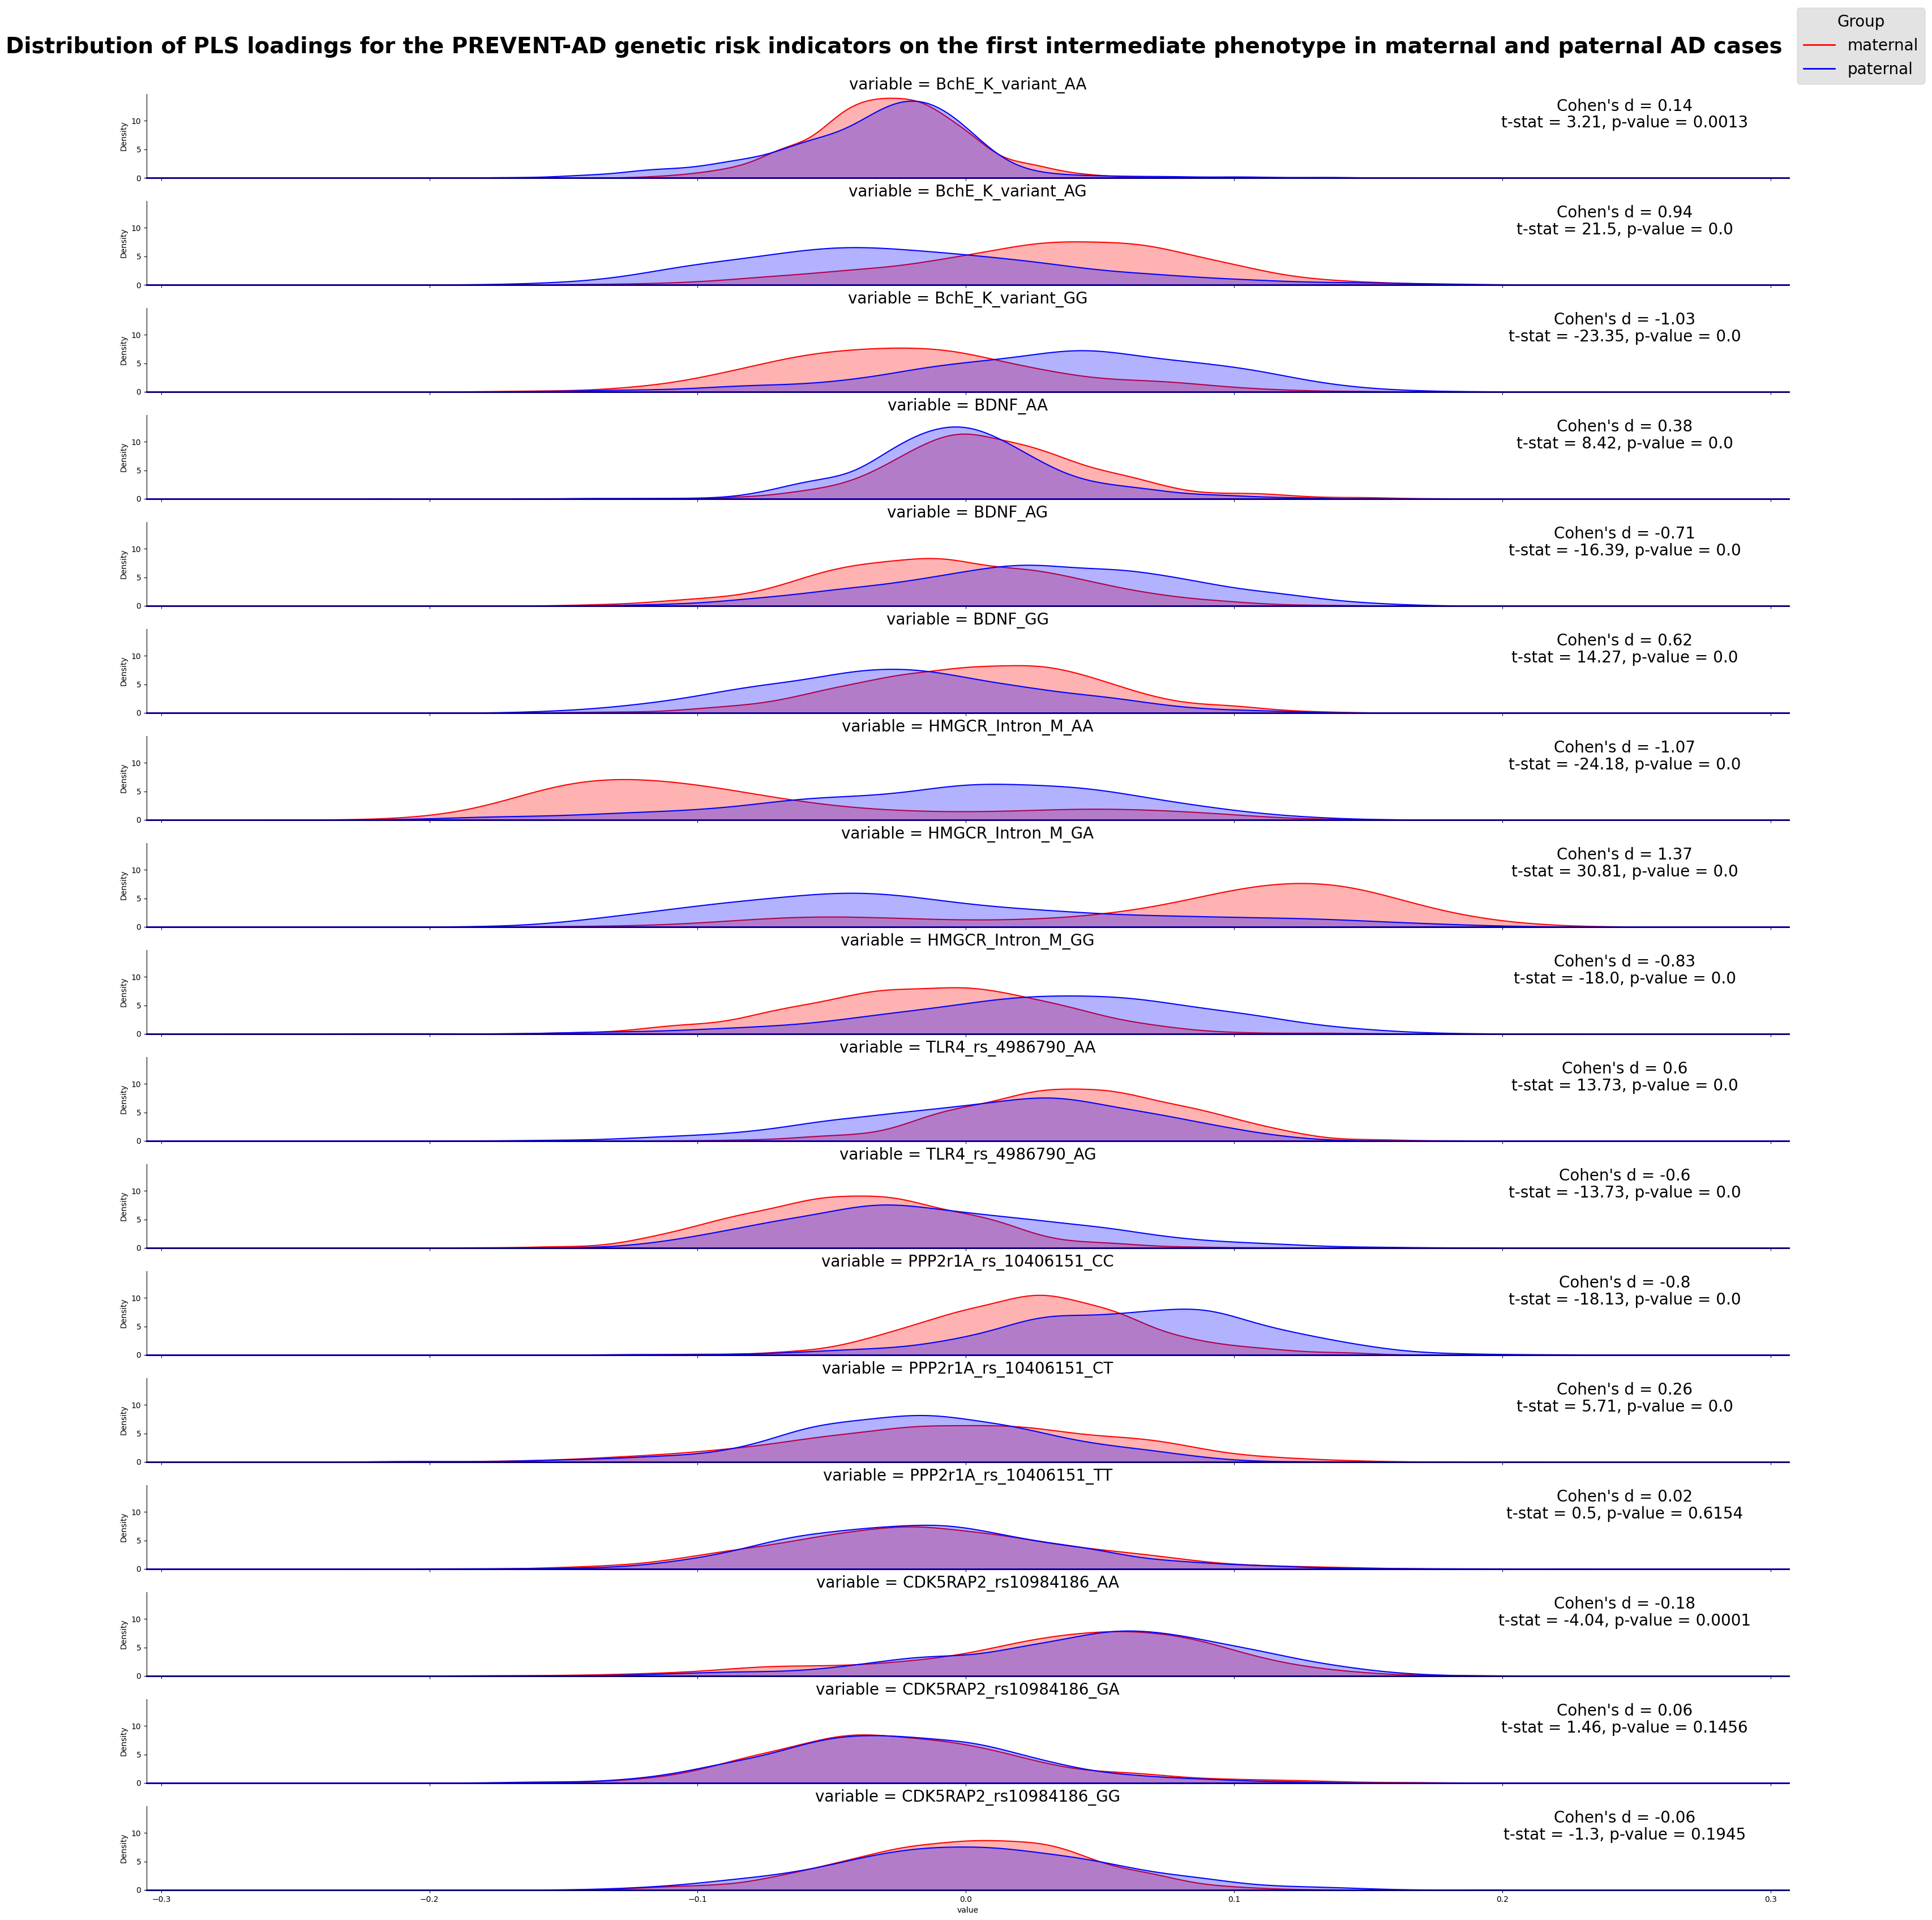

In [37]:

melt_dfs = pd.concat([mat_melt, pat_melt])
# Create a FacetGrid for one of the datasets (mat_melt), but leave room to add the second dataset's kdeplots
g = sns.FacetGrid(melt_dfs, row='variable', hue='group', aspect=15, height=2, palette=['red','blue'])

# Add the KDE plot for the first dataset (mat_melt)
g.map(sns.kdeplot, 'value',
      bw_adjust=1, clip_on=False,
      fill=True, alpha=0.3, linewidth=1.5)  # Adjust alpha for transparency

# Add horizontal lines for the plots
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.set_titles(size=20)  # Adjust the size parameter as needed

g.add_legend(fontsize=20, loc='upper right', title='Group', title_fontproperties={'size':30})
legend = g._legend
legend.get_title().set_fontsize(20)  # Change the legend title font size
legend.get_frame().set_visible(True)  # Make sure the frame is visible
legend.get_frame().set_color('gainsboro')  # Set the edge color of the box
legend.get_frame().set_linewidth(2)  # Set the line width of the box

# Add Cohen's d value to the corresponding density plot
marker = 0 
for ax in g.axes.flat:
    ax.text(0.9, 0.95, f"Cohen's d = {cohens_d.round(2)[marker]}", transform=ax.transAxes,
            ha='center', va='top', fontsize=20, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
    ax.text(0.9, 0.75, f"t-stat = {np.round(t_statistic[marker],2)}, p-value = {np.round(p_value[marker],4)}", transform=ax.transAxes,
            ha='center', va='top', fontsize=20, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
    marker +=1

# Show the plot
plt.suptitle("Distribution of PLS loadings for the PREVENT-AD genetic risk indicators on the first intermediate phenotype in maternal and paternal AD cases", fontsize=28, fontweight='bold', x=0.43)
plt.subplots_adjust(top=0.95)
plt.show()
plt.close('all')

In [38]:
#  T-test
t_statistic = comp1_results_fem_mal.loc[rows]['t_stats']
p_value = comp1_results_fem_mal.loc[rows]['p_value']

# means
mean_red = comp1_results_fem_mal.loc[rows]['mean 1']
mean_blue = comp1_results_fem_mal.loc[rows]['mean 2']

# standard deviations
std_red = comp1_results_fem_mal.loc[rows]['std 1']  # Sample standard deviation
std_blue = comp1_results_fem_mal.loc[rows]['std 2']

# Cohen's d
cohens_d = comp1_results_fem_mal.loc[rows]["Cohen's d"]

print("Cohen's d:", cohens_d)

Cohen's d: BchE_K_variant_AA         0.504264
BchE_K_variant_AG        -0.802516
BchE_K_variant_GG         0.633683
BDNF_AA                   0.294982
BDNF_AG                   1.924458
BDNF_GG                  -2.019697
HMGCR_Intron_M_AA         1.036903
HMGCR_Intron_M_GA        -0.393406
HMGCR_Intron_M_GG        -1.276058
TLR4_rs_4986790_AA        1.026898
TLR4_rs_4986790_AG       -1.026898
PPP2r1A_rs_10406151_CC    1.743853
PPP2r1A_rs_10406151_CT    0.054888
PPP2r1A_rs_10406151_TT   -1.106970
CDK5RAP2_rs10984186_AA    0.804166
CDK5RAP2_rs10984186_GA    0.098434
CDK5RAP2_rs10984186_GG   -0.587537
Name: Cohen's d, dtype: float64


In [39]:
# Compute the mean across rows (axis=1) for the female matrix,
# then reset index and rename columns for clarity
fem_mean_df = pd.DataFrame(comp_1_fem.loc[rows].mean(axis=1)) \
    .reset_index() \
    .rename(columns={'index': 'variable', 0: 'mean'})

# Transpose female data and melt into long format
fem_melt = pd.melt(comp_1_fem.loc[rows].T.reset_index(), id_vars="index")

# Merge the melted female data with the corresponding mean values by 'variable'
fem_melt = fem_melt.merge(fem_mean_df, on='variable')

# Add a new column indicating that these observations are from females
fem_melt['group'] = 'females'

# Repeat the same procedure for the male matrix:
# Compute the row means and reformat into a tidy DataFrame
mal_mean_df = pd.DataFrame(comp_1_mal.loc[rows].mean(axis=1)) \
    .reset_index() \
    .rename(columns={'index': 'variable', 0: 'mean'})

# Transpose and melt the male data into long format
mal_melt = pd.melt(comp_1_mal.loc[rows].T.reset_index(), id_vars="index")

# Merge with mean values by 'variable' for male data
mal_melt = mal_melt.merge(mal_mean_df, on='variable')

# Add a new column indicating that these observations are from males
mal_melt['group'] = 'males'


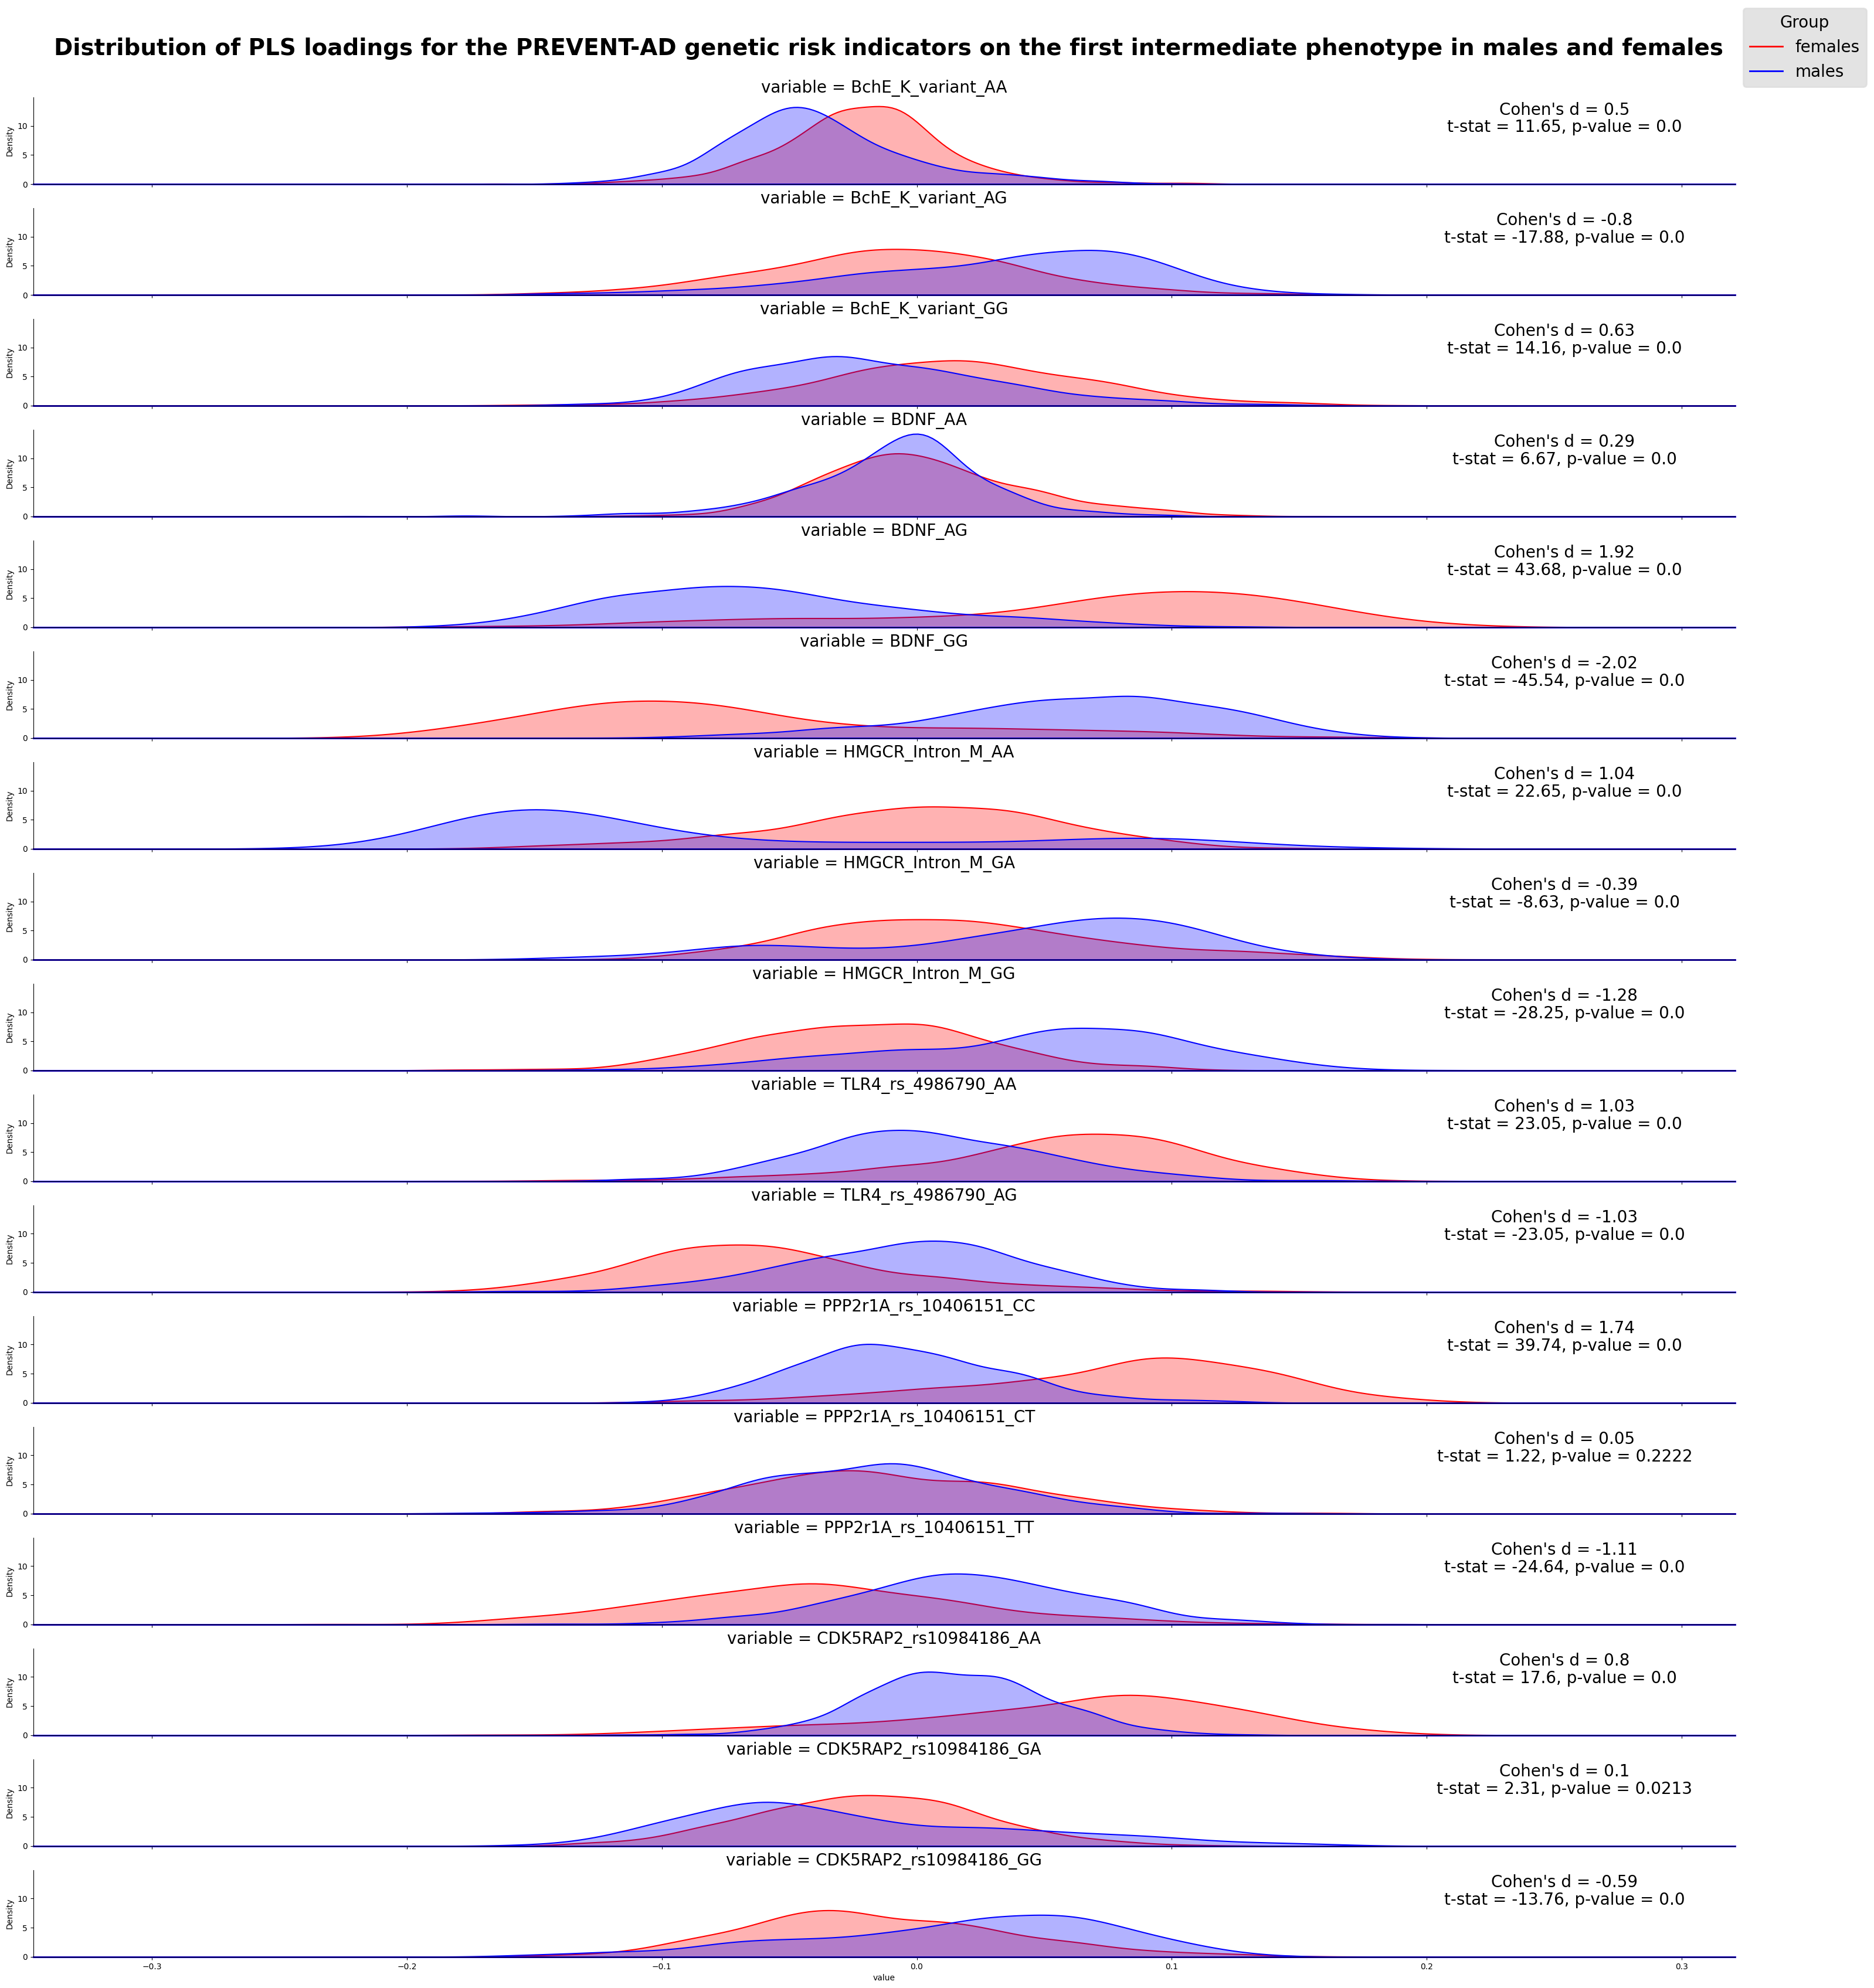

In [40]:
# print("Cohen's d:", cohens_d)

melt_dfs = pd.concat([fem_melt, mal_melt])
# Create a FacetGrid for one of the datasets (mat_melt), but leave room to add the second dataset's kdeplots
g = sns.FacetGrid(melt_dfs, row='variable', hue='group', aspect=15, height=2, palette=['red','blue'])

# Add the KDE plot for the first dataset (mat_melt)
g.map(sns.kdeplot, 'value',
      bw_adjust=1, clip_on=False,
      fill=True, alpha=0.3, linewidth=1.5)  # Adjust alpha for transparency

# Add horizontal lines for the plots
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.set_titles(size=20)  # Adjust the size parameter as needed

# Adjust the legend title font size after adding it
g.add_legend(fontsize=20, loc='upper right', title='Group', title_fontproperties={'size':30})
legend = g._legend
legend.get_title().set_fontsize(20)  # Change the legend title font size
legend.get_frame().set_visible(True)  # Make sure the frame is visible
legend.get_frame().set_color('gainsboro')  # Set the edge color of the box
legend.get_frame().set_linewidth(2)  # Set the line width of the box

# Add Cohen's d value to the corresponding density plot
marker = 0 
for ax in g.axes.flat:
    ax.text(0.9, 0.95, f"Cohen's d = {cohens_d.round(2)[marker]}", transform=ax.transAxes,
            ha='center', va='top', fontsize=20, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
    ax.text(0.9, 0.75, f"t-stat = {np.round(t_statistic[marker],2)}, p-value = {np.round(p_value[marker],4)}", transform=ax.transAxes,
            ha='center', va='top', fontsize=20, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
    marker +=1

# Show the plot
plt.suptitle("Distribution of PLS loadings for the PREVENT-AD genetic risk indicators on the first intermediate phenotype in males and females", fontsize=28, fontweight='bold', x=0.475)
plt.subplots_adjust(top=0.95) 
plt.show()
plt.close('all')


### Plotting

In [41]:
# Run PLS and extract latent components for maternal and paternal AD lineage
pls_mat = pls_loadings(df_mat,'individuals with maternal history of ADRD')
pls_pat = pls_loadings(df_pat,'individuals with paternal history of ADRD')
# Match and align PLS components between the two subgroups
# Consider the top 5 components when doing the matching but only return the top 3 
loadings_mat_df = match_comps(og_pls, pls_mat, 5, 3)
loadings_pat_df = match_comps(og_pls, pls_pat, 5, 3)

# Run PLS and extract latent components for males and females sex
pls_males = pls_loadings(df_males,'males')
pls_females = pls_loadings(df_females,'females')
# Match and align PLS components between the two subgroups
# Consider the top 5 components when doing the matching but only return the top 3 
loadings_females_df = match_comps(og_pls, pls_males, 5, 3)
loadings_males_df = match_comps(og_pls, pls_females, 5, 3)

#### Visualizing sex and lineage biases

In [42]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [43]:
print(date)

25.05.13


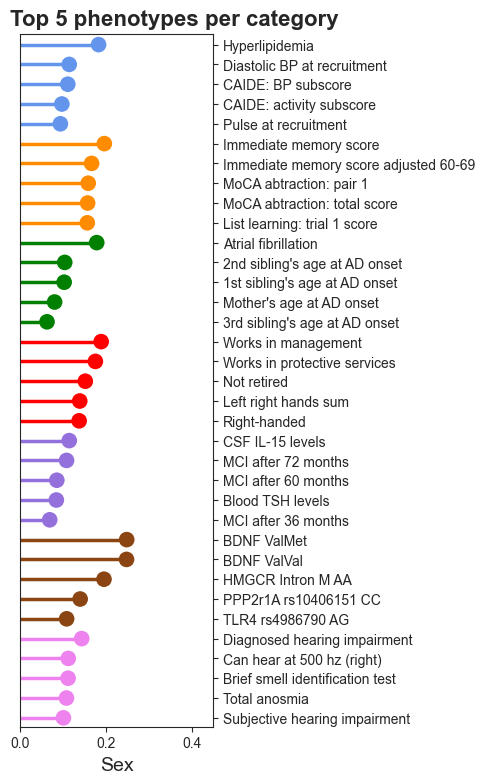

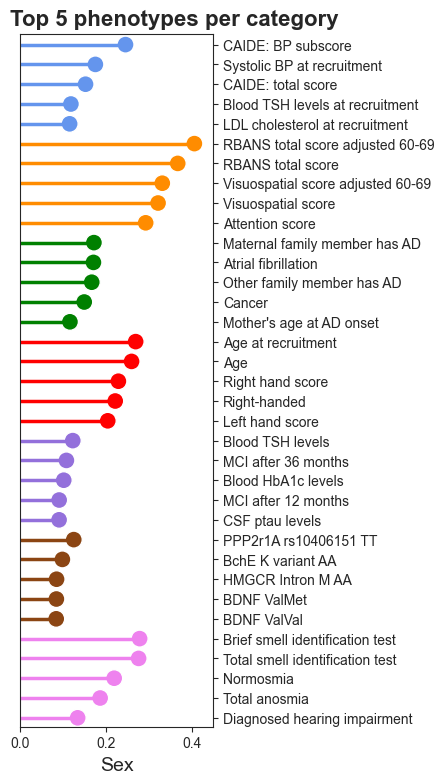

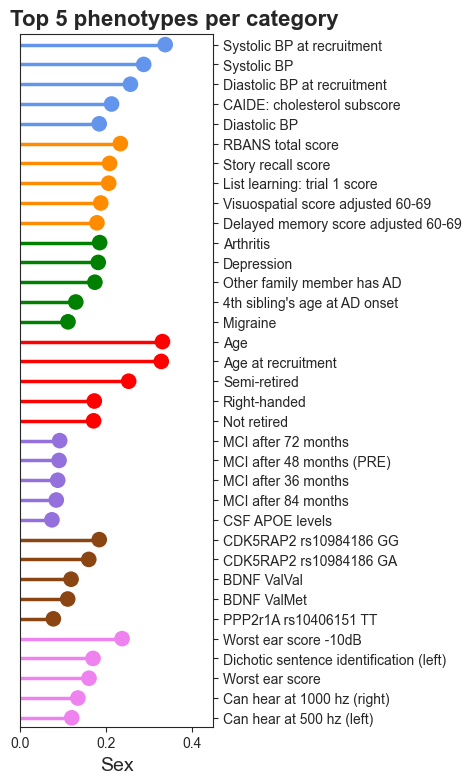

In [44]:
os.makedirs(f"{date}/lollipop_plots", exist_ok=True)

file=1
for c in range(0, 3):
    diff_f_m = loadings_females_df[c] - loadings_males_df[c]
    diff_f_m.rename(index=names_dict, inplace=True)
    p_vals = pd.read_csv(f'Supplementary_Table_{file}.csv', index_col=0)
    # Apply p-value filter
    mask = p_vals.p_value > 0.05
    diff_f_m[mask] = np.nan
    file +=2

    tmp = pd.DataFrame(abs(np.array(diff_f_m)), columns=['f_m'])
    tmp['cat'] = cat
    tmp['phens'] = diff_f_m.index
    tmp['abs_val'] = tmp['f_m'].abs()

    # Preserve the order
    cat_order = tmp.groupby('cat').mean(numeric_only=True).index.tolist()
    colors = ['cornflowerblue', 'darkorange', 'green', 'red', 'mediumpurple', 'saddlebrown', 'violet']
    palette = dict(zip(cat_order, colors[:len(cat_order)]))
    cat_order.reverse()

    # Collect top N per category
    top_n = 5
    top_rows = []

    for cat_name in cat_order:
        df_cat = tmp[tmp['cat'] == cat_name]
        top_cat = df_cat.sort_values(by='abs_val', ascending=False).head(top_n)
        top_rows.append(top_cat)

    combined_df = pd.concat(top_rows, axis=0)

    # Force category ordering
    combined_df['cat'] = pd.Categorical(combined_df['cat'], categories=cat_order, ordered=True)

    # Sort by category and then by value within each category
    combined_df = combined_df.sort_values(by=['cat', 'f_m'], ascending=[True, True])

    # Optionally customize y-labels to include category
    combined_df['label'] = combined_df['phens']

    # Plot (Lollipop)
    sns.set_style("white")
    sns.set_style("ticks")

    plt.figure(figsize=(2.5, 0.2 * len(combined_df) + 2), dpi=100)
    ax = sns.scatterplot(
        data=combined_df,
        y="label",
        x="f_m",
        hue="cat",
        palette=palette,
        s=150,  # size of the markers
        marker="o",
    )

    # Move y-axis labels and ticks to the right
    ax.yaxis.set_label_position('right')
    ax.yaxis.tick_right()
    
    # Draw lines connecting the points to the x-axis
    for i in range(len(combined_df)):
        ax.plot([0, combined_df['f_m'].iloc[i]], [i, i], color=palette[combined_df['cat'].iloc[i]], lw=2.5)

    plt.legend().set_visible(False)
    plt.title(f"Top {top_n} phenotypes per category", fontsize=16, fontweight='bold', x=0.8)
    plt.xlabel("Sex", fontsize=14)
    plt.ylabel('')
    plt.ylim(-0.45,len(combined_df)-0.45)
    plt.xlim(0,0.45)
    plt.savefig(f"{date}/lollipop_plots/component_{c+1}_all_categories_lollipop_sex.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

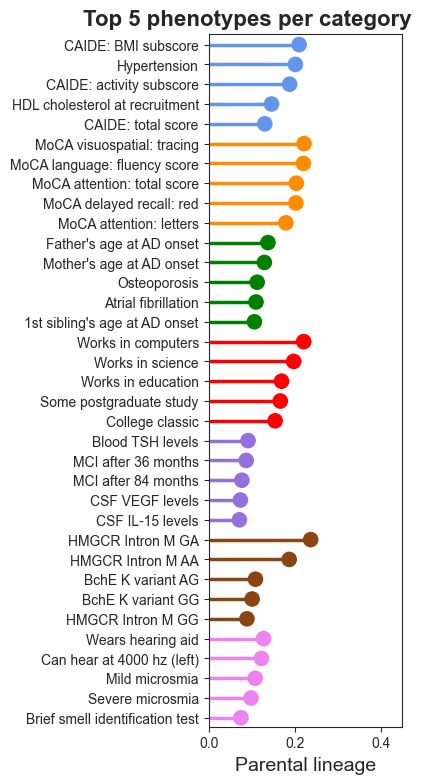

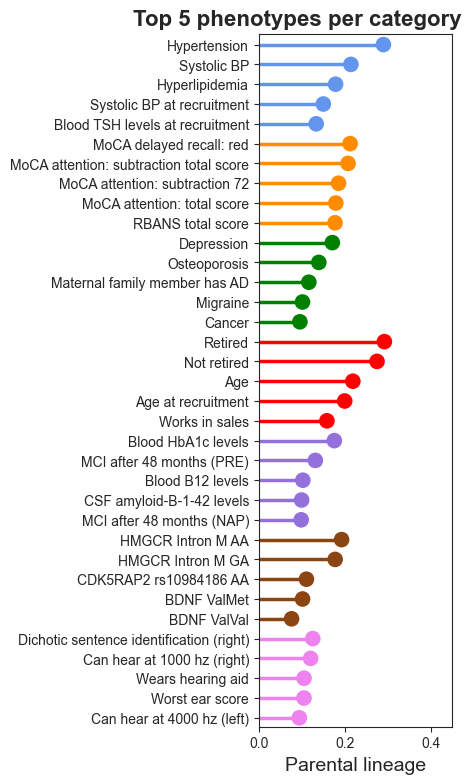

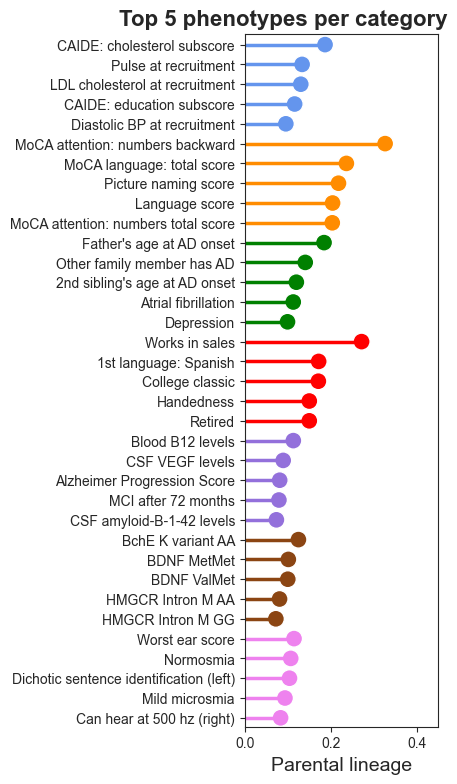

In [45]:
os.makedirs(f"{date}/lollipop_plots", exist_ok=True)

file = 2
for c in range(0, 3):
    diff_mat_pat = loadings_mat_df[c] - loadings_pat_df[c]
    diff_mat_pat.rename(index=names_dict, inplace=True)
    p_vals = pd.read_csv(f'Supplementary_Table_{file}.csv', index_col=0)
    # Apply p-value filter
    mask = p_vals.p_value > 0.05
    diff_mat_pat[mask] = np.nan
    file += 2

    tmp = pd.DataFrame(abs(np.array(diff_mat_pat)), columns=['mat_pat'])
    tmp['f_m'] = np.array(diff_mat_pat)
    tmp['cat'] = cat
    tmp['phens'] = diff_mat_pat.index
    tmp['abs_val'] = tmp['mat_pat'].abs()

    # Preserve the order
    cat_order = tmp.groupby('cat').mean(numeric_only=True).index.tolist()
    colors = ['cornflowerblue', 'darkorange', 'green', 'red', 'mediumpurple', 'saddlebrown', 'violet']
    palette = dict(zip(cat_order, colors[:len(cat_order)]))
    cat_order.reverse()

    # Collect top N per category
    top_n = 5
    top_rows = []

    for cat_name in cat_order:
        df_cat = tmp[tmp['cat'] == cat_name]
        top_cat = df_cat.sort_values(by='abs_val', ascending=False).head(top_n)
        top_rows.append(top_cat)

    combined_df = pd.concat(top_rows, axis=0)

    # Force category ordering
    combined_df['cat'] = pd.Categorical(combined_df['cat'], categories=cat_order, ordered=True)

    # Sort by category and then by value within each category
    combined_df = combined_df.sort_values(by=['cat', 'mat_pat'], ascending=[True, True])

    # Optionally customize y-labels to include category
    combined_df['label'] = combined_df['phens']

    sns.set_style("white")
    sns.set_style("ticks")
    # Plot (Lollipop)
    plt.figure(figsize=(2.5, 0.2 * len(combined_df) + 2), dpi=100)
    ax = sns.scatterplot(
        data=combined_df,
        y="phens",
        x="abs_val",
        hue="cat",
        palette=palette,
        s=150,  # size of the markers
        marker="o",
    )
    
    # Draw lines connecting the points to the x-axis
    for i in range(len(combined_df)):
        ax.plot([0, combined_df['mat_pat'].iloc[i]], [i, i], color=palette[combined_df['cat'].iloc[i]], lw=2.5)

    plt.legend().set_visible(False)
    plt.title(f"Top {top_n} phenotypes per category", fontsize=16, fontweight='bold', x=0.2)
    plt.xlabel("Parental lineage", fontsize=14)
    plt.ylabel('')
    plt.ylim(-0.45,len(combined_df)-0.45)
    plt.xlim(0,0.45)
    plt.savefig(f"{date}/lollipop_plots/component_{c+1}_all_categories_lollipop_lineage.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

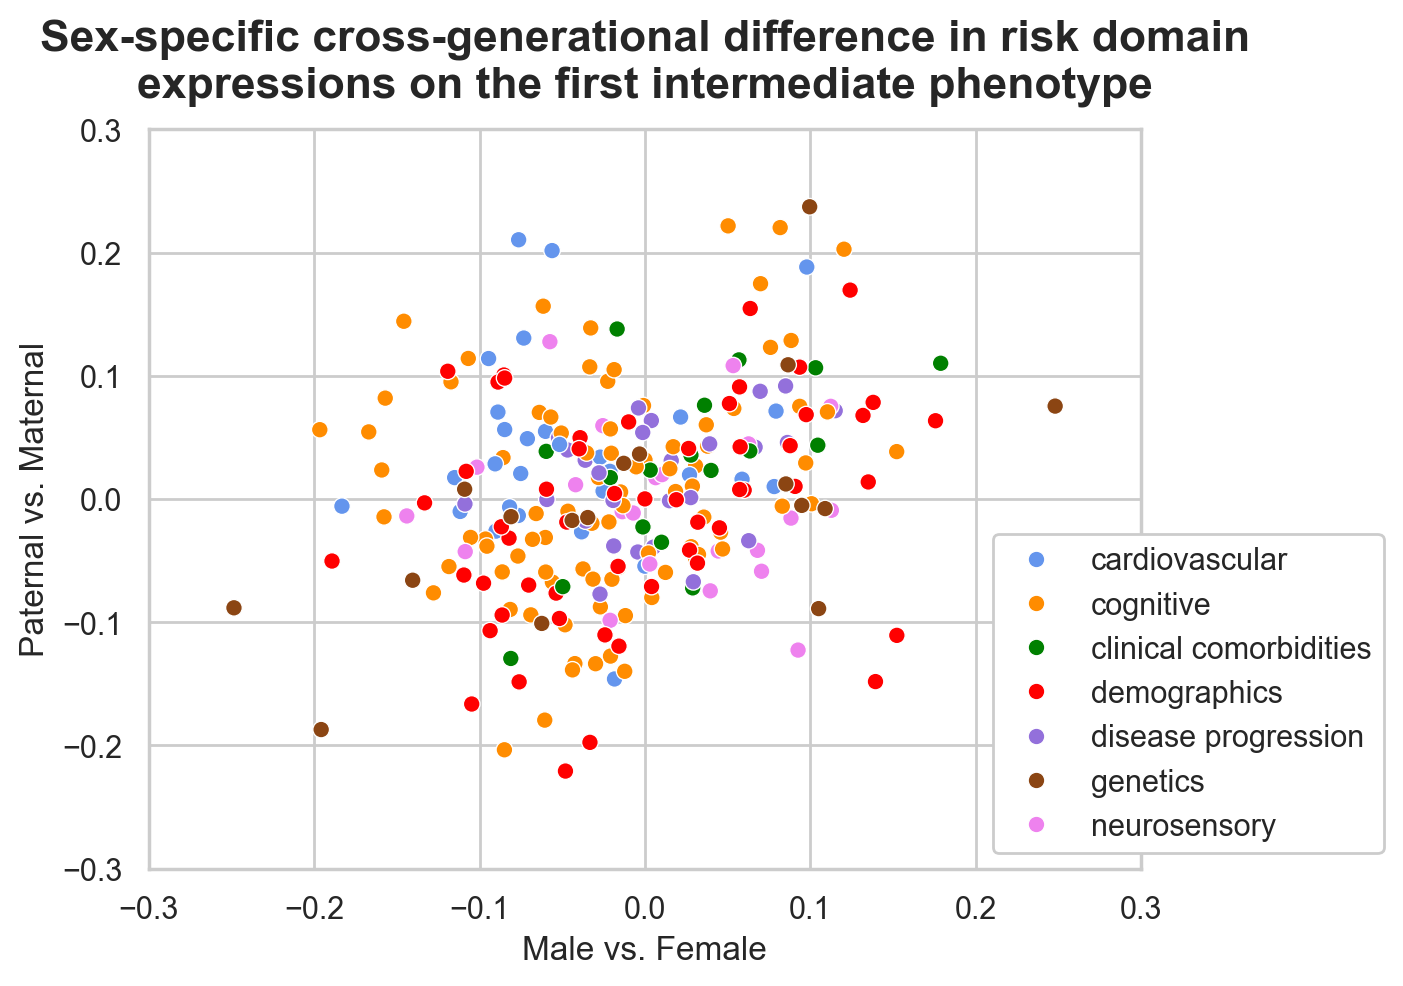

In [46]:
for c in range(0,1):
    diff_mat_pat = loadings_mat_df[c]-loadings_pat_df[c]
    diff_f_m = loadings_females_df[c]-loadings_males_df[c]

    tmp = pd.DataFrame(np.array(diff_mat_pat),columns=['mat_pat'])
    tmp['f_m'] = np.array(diff_f_m)
    #print(cat)
    tmp['cat'] = cat
    new_cat = []
    for ca in cat:
        ca = ca.replace('_',' ')
        ca = ca.replace('comorbidities','clinical comorbidities')
        new_cat.append(ca)
    tmp['new_cat']=new_cat
    cat_order = list(tmp.groupby('new_cat').mean().index)
    cat_order[1]='cognitive'
    cat_order[2]='clinical comorbidities'

    # Define your custom colors and map them to the categories
    colors = ['cornflowerblue', 'darkorange', 'green', 'red', 'mediumpurple', 'saddlebrown', 'violet']

    # Ensure `cat_order` has the same length as your color list
    palette = dict(zip(cat_order, colors[:len(cat_order)]))

    # Set the style for a clean white background
    sns.set(style="whitegrid")

    plt.figure(dpi=200)
    g = sns.scatterplot(
        x='f_m',
        y="mat_pat",
        data=tmp,
        hue="new_cat",
        hue_order=cat_order,
        palette=palette  # Use your custom palette here
    )

    g.legend(loc='lower right', ncol=1, bbox_to_anchor=(1.26, 0), framealpha=1)

    plt.title(f'Sex-specific cross-generational difference in risk domain\nexpressions on the first intermediate phenotype', fontsize=16, fontweight='bold', y=1.02)
    plt.ylabel('Paternal vs. Maternal', fontsize=12)
    plt.xlabel('Male vs. Female', fontsize=12)
    plt.ylim(-0.30, 0.30)
    plt.xlim(-0.30, 0.30)

    plt.savefig(f'{date}/diffs_C{c+1}.png', dpi=200, bbox_inches='tight', facecolor='white')
    plt.show()


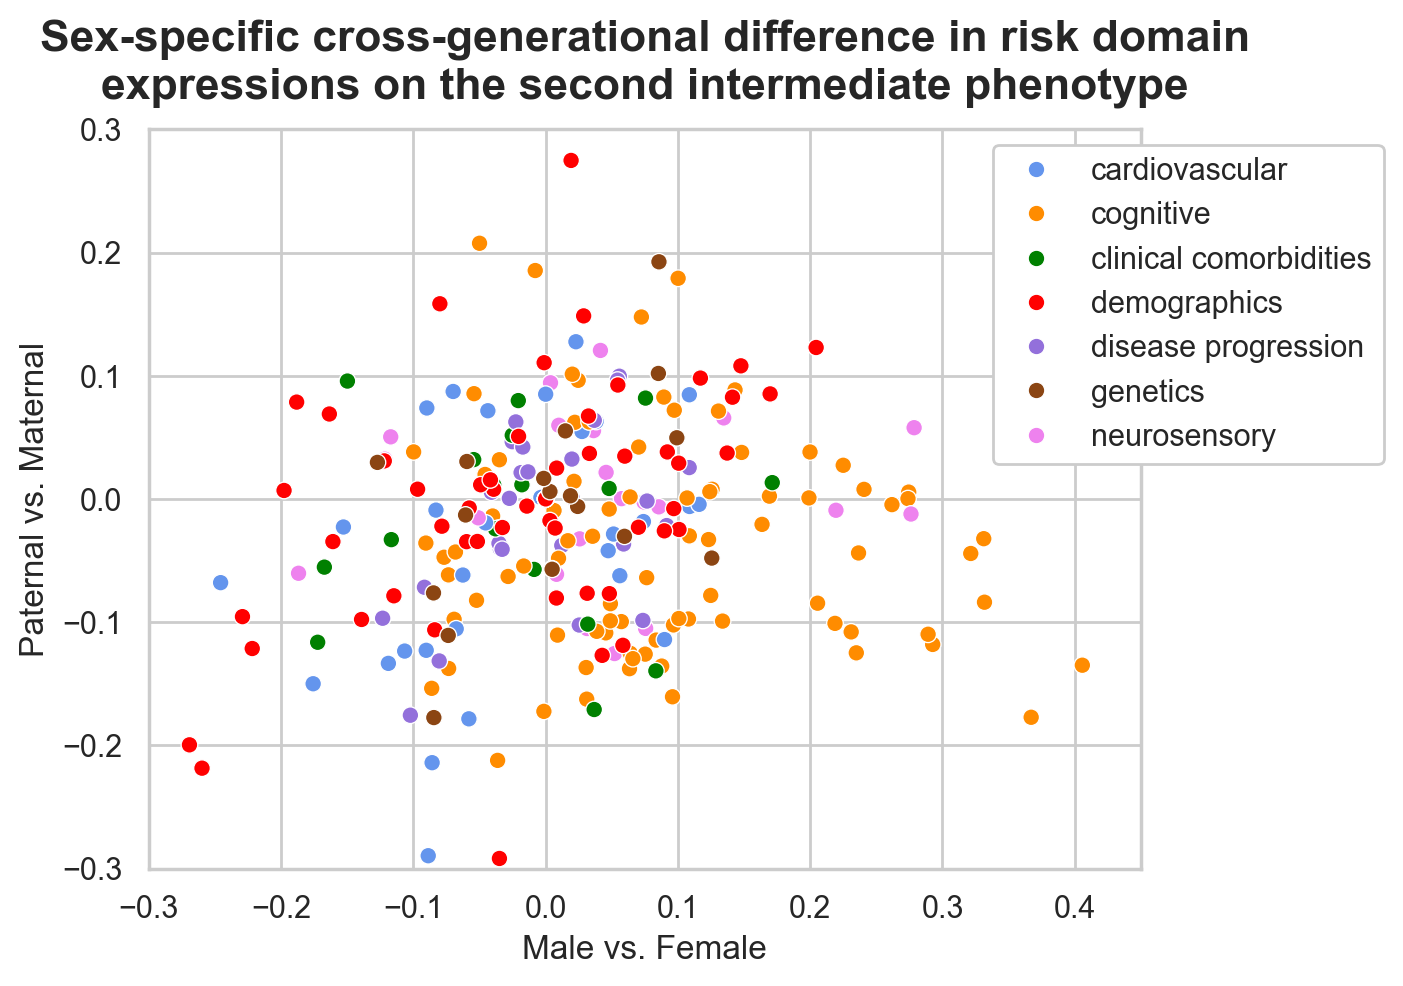

In [47]:
for c in range(1,2):
    diff_mat_pat = loadings_mat_df[c]-loadings_pat_df[c]
    diff_f_m = loadings_females_df[c]-loadings_males_df[c]

    tmp = pd.DataFrame(np.array(diff_mat_pat),columns=['mat_pat'])
    tmp['f_m'] = np.array(diff_f_m)
    #print(cat)
    tmp['cat'] = cat
    new_cat = []
    for ca in cat:
        ca = ca.replace('_',' ')
        ca = ca.replace('comorbidities','clinical comorbidities')
        new_cat.append(ca)
    tmp['new_cat']=new_cat
    cat_order = list(tmp.groupby('new_cat').mean().index)
    cat_order[1]='cognitive'
    cat_order[2]='clinical comorbidities'

    # Define your custom colors and map them to the categories
    colors = ['cornflowerblue', 'darkorange', 'green', 'red', 'mediumpurple', 'saddlebrown', 'violet']

    # Ensure `cat_order` has the same length as your color list
    palette = dict(zip(cat_order, colors[:len(cat_order)]))

    # Set the style for a clean white background
    sns.set(style="whitegrid")

    plt.figure(dpi=200)
    g = sns.scatterplot(
        x='f_m',
        y="mat_pat",
        data=tmp,
        hue="new_cat",
        hue_order=cat_order,
        palette=palette  # Use your custom palette here
    )

    g.legend(loc='upper right', ncol=1, bbox_to_anchor=(1.26, 1), framealpha=1)

    plt.title(f'Sex-specific cross-generational difference in risk domain\nexpressions on the second intermediate phenotype', fontsize=16, fontweight='bold', y=1.02)
    plt.ylabel('Paternal vs. Maternal', fontsize=12)
    plt.xlabel('Male vs. Female', fontsize=12)
    plt.ylim(-0.30, 0.30)
    plt.xlim(-0.30, 0.45)

    plt.savefig(f'{date}/diffs_C{c+1}.png', dpi=200, bbox_inches='tight', facecolor='white')
    plt.show()


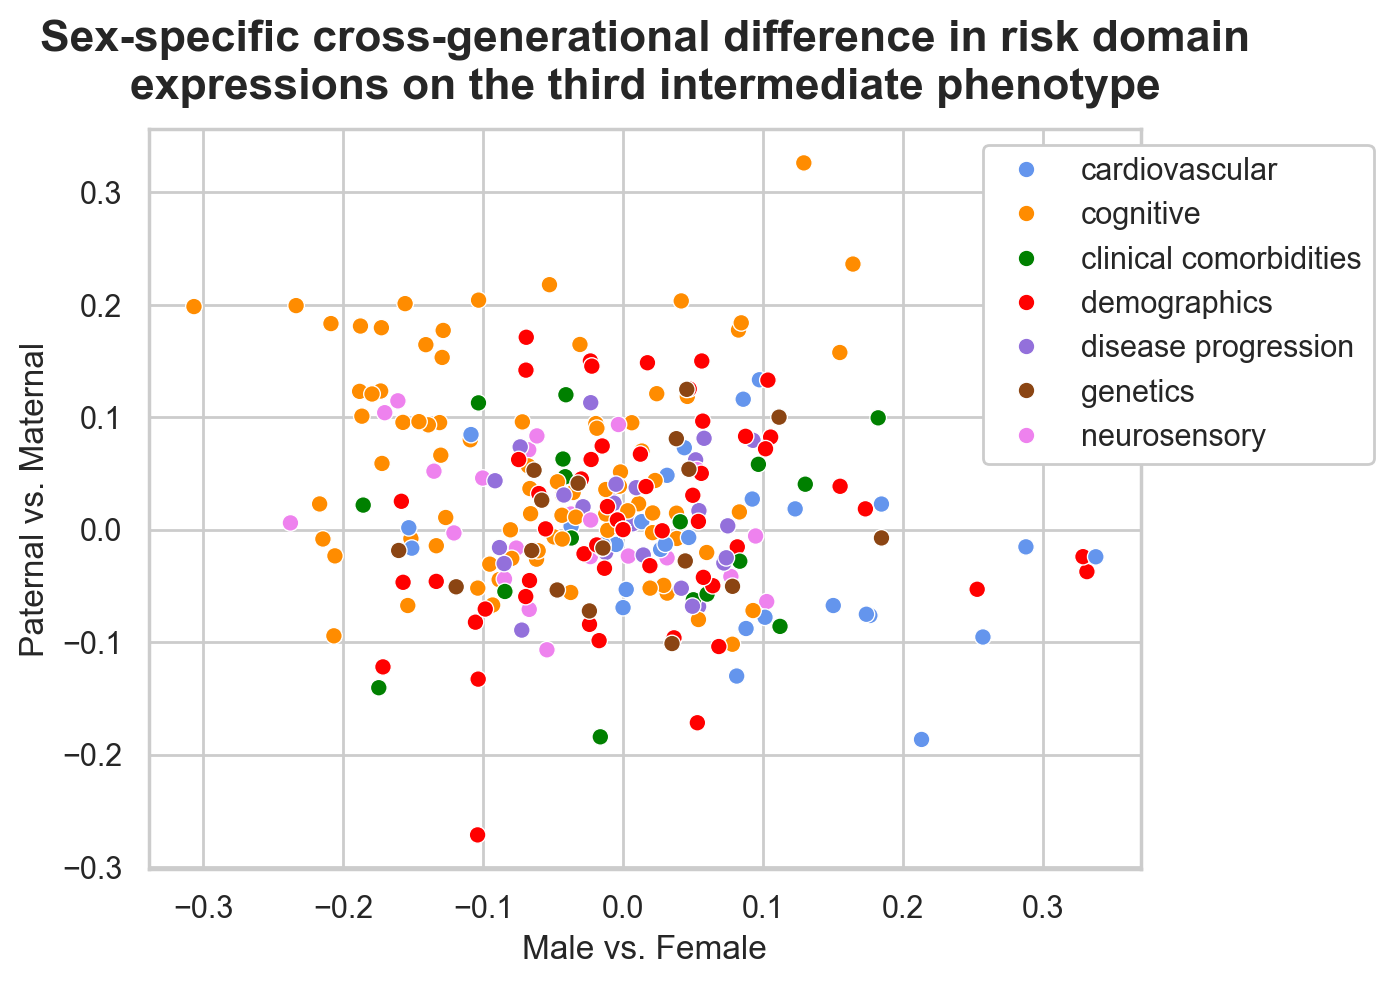

In [48]:
for c in range(2,3):
    diff_mat_pat = loadings_mat_df[c]-loadings_pat_df[c]
    diff_f_m = loadings_females_df[c]-loadings_males_df[c]

    tmp = pd.DataFrame(np.array(diff_mat_pat),columns=['mat_pat'])
    tmp['f_m'] = np.array(diff_f_m)
    #print(cat)
    tmp['cat'] = cat
    new_cat = []
    for ca in cat:
        ca = ca.replace('_',' ')
        ca = ca.replace('comorbidities','clinical comorbidities')
        new_cat.append(ca)
    tmp['new_cat']=new_cat
    cat_order = list(tmp.groupby('new_cat').mean().index)
    cat_order[1]='cognitive'
    cat_order[2]='clinical comorbidities'

    # Define your custom colors and map them to the categories
    colors = ['cornflowerblue', 'darkorange', 'green', 'red', 'mediumpurple', 'saddlebrown', 'violet']

    # Ensure `cat_order` has the same length as your color list
    palette = dict(zip(cat_order, colors[:len(cat_order)]))

    # Set the style for a clean white background
    sns.set(style="whitegrid")

    plt.figure(dpi=200)
    g = sns.scatterplot(
        x='f_m',
        y="mat_pat",
        data=tmp,
        hue="new_cat",
        hue_order=cat_order,
        palette=palette  # Use your custom palette here
    )

    g.legend(loc='upper right', ncol=1, bbox_to_anchor=(1.25, 1), framealpha=1)

    plt.title(f'Sex-specific cross-generational difference in risk domain\nexpressions on the third intermediate phenotype', fontsize=16, fontweight='bold', y=1.02)
    plt.ylabel('Paternal vs. Maternal', fontsize=12)
    plt.xlabel('Male vs. Female', fontsize=12)
    # plt.ylim(-0.40, 0.35)
    # plt.xlim(-0.35, 0.35)

    plt.savefig(f'{date}/diffs_C{c+1}.png', dpi=200, bbox_inches='tight', facecolor='white')
    plt.show()


### Use Plotly to make interactve scatter plot

In [49]:
import plotly.express as px
# pip install --upgrade nbformat

In [50]:
for c in range(0,3):
    diff_mat_pat = loadings_mat_df[c]-loadings_pat_df[c]
    diff_mat_pat.rename(index=names_dict, inplace=True)
    diff_f_m = loadings_females_df[c]-loadings_males_df[c]
    diff_f_m.rename(index=names_dict, inplace=True)

    tmp = pd.DataFrame(np.array(diff_mat_pat),columns=['mat_pat'])
    tmp['f_m'] = np.array(diff_f_m)
    tmp['cat'] = cat
    tmp['phens'] = diff_mat_pat.index
    
    cat_order = tmp.groupby('cat').mean().index
    tmp = tmp.sort_values(by='cat')
        
    fig = px.scatter(tmp, x="f_m", y="mat_pat",color='cat', hover_name='phens',
                     color_discrete_sequence=['cornflowerblue', 'darkorange', 'green', 'red', 'mediumpurple', 'saddlebrown', 'violet'])
    fig.show()

# Longitudinal analyses

In [51]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [52]:
# Meternal AD lineage
id_mat = np.where(z_df_df.only_mother>0)
df_mat = z_df_df.iloc[id_mat]

# Paternal AD lineage
id_pat = np.where(z_df_df.only_father>0)
df_pat = z_df_df.iloc[id_pat]

# Male sex
id_males = np.where(z_df_df.Sex_Male>0)
df_males = z_df_df.iloc[id_males]

#Female sex
id_females = np.where(z_df_df.Sex_Female>0)
df_females = z_df_df.iloc[id_females]

In [53]:
df_gr = z_df_df
inds = pd.MultiIndex.from_frame(df_gr[['CandID','time_diff']])
df_gr = df_gr.set_index(inds)

In [54]:
len(df_gr.index.get_level_values('CandID').unique())

233

In [55]:
# Initialize empty DataFrames to store first and last visits
t1_df = pd.DataFrame()  # DataFrame to store first visits (T1) for each participant
t2_df = pd.DataFrame()  # DataFrame to store last visits (T2) for each participant

# Loop through all unique participants in the DataFrame
for participant in df_gr.index.get_level_values('CandID').unique():
    
    # Convert participant ID to integer
    participant = int(participant)
    
    # Select all visits corresponding to this participant
    visits = df_gr.xs(participant)
    
    # Sort visits chronologically by the index (e.g., time or visit order)
    visits = visits.sort_index()

    # Only process participants who have at least two visits
    if len(visits.index) > 1:
        
        # Get the first visit (baseline)
        t1 = visits.iloc[0, :]

        # Get the last visit (follow-up)
        t2 = visits.iloc[-1, :]

        # Append the visits to the respective DataFrames
        t1_df = t1_df.append(t1, ignore_index=True)
        t2_df = t2_df.append(t2, ignore_index=True)


In [56]:
def make_time_dfs(df_gr,idx):

    """
    Constructs two DataFrames containing the first (T1) and last (T2) visits 
    for each participant who has multiple time points.

    Parameters:
    -----------
    df_gr : DataFrame
        Full longitudinal dataset.
    idx : list or array-like
        Indices of participants to include.

    Returns:
    --------
    t1_df : DataFrame
        Contains the first time point for each included participant.
    t2_df : DataFrame
        Contains the last time point for each included participant.
    """
    
    # Subset the global dataframe using the provided indices
    df_gr = z_df_df.iloc[idx]
    # Create a MultiIndex using participant ID and time point
    inds = pd.MultiIndex.from_frame(df_gr[['CandID','time_diff']])
    df_gr = df_gr.set_index(inds)
    
    # Initialize DataFrames to store the earliest and latest visits
    t1_df = pd.DataFrame()
    t2_df = pd.DataFrame()

    # Print number of unique participants being processed
    print(len(df_gr.index.get_level_values('CandID').unique()))
    
    count = 0
    #loop through all participants
    for participant in df_gr.index.get_level_values('CandID').unique():
        count+=1

        # Get all visits for this participant, sort chronologically
        participant = int(participant)
        visits = df_gr.xs(participant)
        visits = visits.sort_index()

        # Proceed only if the participant has at least two visits  
        if len(visits.index)>1:
            # Select the first and last visit
            t1 = visits.iloc[0,:]
            t2 = visits.iloc[-1,:]

            # Append to respective DataFrames
            t1_df = t1_df.append(t1,ignore_index=True)
            t2_df = t2_df.append(t2,ignore_index=True)
    
    # Print shape of resulting T1 dataframe (number of valid participants)
    print(t1_df.shape)

    return t1_df, t2_df

In [57]:
# Maternal lineage
df_mat_1, df_mat_2 = make_time_dfs(df_mat,id_mat)
# Paternal lineage
df_pat_1, df_pat_2 = make_time_dfs(df_pat,id_pat)

# Male sex
df_males_1, df_males_2 = make_time_dfs(df_males,id_males)
# Female sex
df_females_1, df_females_2 = make_time_dfs(df_females,id_females)

156
(82, 328)
77
(44, 328)
77
(57, 328)
156
(69, 328)


In [58]:
def pls_loadings(df,tag):
    
    # Data normalization and standarization
    scaler = StandardScaler()
    z_scored = scaler.fit_transform(df)
    z_scored_df = pd.DataFrame(z_scored, columns = df.columns)
    
    pls = partial_least_square(z_scored_df, all_phens_cols, apoe_gen, 5, plot=False, tag=tag)
    
    return pls

In [59]:
# Maternal PLS at T1 and T2
pls_mat_1 = pls_loadings(df_mat_1,'mat')
pls_mat_2 = pls_loadings(df_mat_2,'mat')

# Paternal PLS at T1 and T2
pls_pat_1 = pls_loadings(df_pat_1,'pat')
pls_pat_2 = pls_loadings(df_pat_2,'pat')

# Male PLS at T1 and T2
pls_males_1 = pls_loadings(df_males_1,'males')
pls_males_2 = pls_loadings(df_males_2,'males')

# Female PLS at T1 and T2
pls_females_1 = pls_loadings(df_females_1, 'females')
pls_females_2 = pls_loadings(df_females_2, 'females')

In [60]:
# Match is done using the top 5 components; only the top 3 matched components are returned
# Parental AD lineage
loadings_mat_1 = match_comps(og_pls, pls_mat_1, 5, 3)
loadings_pat_1 = match_comps(og_pls, pls_pat_1, 5, 3)
loadings_mat_2 = match_comps(og_pls, pls_mat_2, 5, 3)
loadings_pat_2 = match_comps(og_pls, pls_pat_2, 5, 3)

# Sex
loadings_females_1 = match_comps(og_pls, pls_females_1, 5, 3)
loadings_males_1 = match_comps(og_pls, pls_males_1, 5, 3)
loadings_females_2 = match_comps(og_pls, pls_females_2, 5, 3)
loadings_males_2 = match_comps(og_pls, pls_males_2, 5, 3)

In [61]:
def loadings_diff(df1_1, df1_2, df2_1, df2_2, comp):   

    """
    Computes the difference in PLS component loadings between two groups 
    (e.g., females vs males or maternal vs paternal history) at two time points (T1 and T2),
    then aggregates those differences by phenotype categories.

    Parameters:
    -----------
    df1_1 : DataFrame
        Group 1 loadings at time point 1.
    df1_2 : DataFrame
        Group 1 loadings at time point 2.
    df2_1 : DataFrame
        Group 2 loadings at time point 1.
    df2_2 : DataFrame
        Group 2 loadings at time point 2.
    comp : str
        Name of the component column to compare (e.g., 'comp_1').

    Returns:
    --------
    DataFrame
        Mean difference in component loadings between groups at T1 and T2,
        grouped by phenotype categories.
    """

    # --- TIME POINT 1 ---

    # Extract component values for both groups
    t1_df = pd.DataFrame(df1_1[comp])  # Group 1
    t2_df = pd.DataFrame(df2_1[comp])  # Group 2
    
    # Compute difference in loadings between groups
    diff_1 = t1_df - t2_df
    diff_1['phens'] = diff_1.index  # Store phenotype identifiers
    diff_1['cat'] = np.array(cat)   # Add phenotype category labels

    # Compute standard deviation per category (not used in return)
    std = diff_1.groupby('cat')[comp].std()

    # Compute mean difference per category
    diff_1 = diff_1.groupby('cat').mean()
    diff_1['time'] = 'T1'  # Label time point
    
    # --- TIME POINT 2 ---

    # Repeat same procedure for second time point
    t1_df = pd.DataFrame(df1_2[comp])  # Group 1
    t2_df = pd.DataFrame(df2_2[comp])  # Group 2

    diff_2 = t1_df - t2_df
    diff_2['phens'] = diff_2.index
    diff_2['cat'] = np.array(cat)

    std2 = diff_2.groupby('cat')[comp].std()

    # Compute mean difference per category
    diff_2 = diff_2.groupby('cat').mean()
    diff_2['time'] = 'T2'

    # Concatenate results for both time points
    tmp = diff_1.append(diff_2)
    tmp['cat'] = tmp.index  # Restore 'cat' column from index

    return tmp

In [62]:
def arrows_plot(tmp, axx, tag, llim, ulim):

    """
    Plot directional arrows showing changes in component loadings between two time points (T1 and T2).

    Parameters:
    ----------
    tmp : pd.DataFrame
        A DataFrame where the first 7 rows correspond to loadings at T1, and the next 7 rows to T2.
    axx : matplotlib.axes.Axes
        The axes object where the plot will be drawn.
    c : str
        The component or variable of interest (not directly used here but assumed to be for context or external labeling).
    tag : str
        A string tag used as the plot title.
    llim : float
        Lower limit for the x-axis.
    ulim : float
        Upper limit for the x-axis.
    """

    # Draw horizontal arrows between T1 and T2 values for each phenotype (one per row)
    axx.hlines(y=range(0, 7), 
               xmin=tmp.iloc[0:7, 0].values.T,  # T1 values
               xmax=tmp.iloc[7:, 0].values,     # T2 values
               color=sns.color_palette("tab10"), alpha=0.4)
    
    # Add scatter markers at the ends of each arrow
    for i in range(0, 7):
        t1_val = tmp.iloc[0:7, 0].values[i]
        t2_val = tmp.iloc[7:, 0].values[i]
        direction = '>' if t1_val < t2_val else '<'  # Decide arrowhead direction

        # Invisible marker at T1 (to define arrow start visually)
        axx.scatter(t1_val, i, color=sns.color_palette("tab10")[i], alpha=0.0, label='T1', marker='_')
        # Visible arrowhead at T2
        axx.scatter(t2_val, i, color=sns.color_palette("tab10")[i], alpha=1.0, label='T2', marker=direction)
    
    axx.set_xlim(llim,ulim)
    labels = list(tmp.index.unique())
    new_labels = []
    print(labels)
    for l in labels:
        l = l.capitalize()
        l = l.replace('_',' ')
        new_labels.append(l)
    axx.set_yticks(range(0,7), new_labels, fontsize='7')

    # Add title and axis names
    axx.set_title(f'{tag}',fontsize=7, fontweight='bold')
    axx.tick_params(axis='x', which='major', labelsize=9)
    axx.invert_yaxis()

['cardiovascular', 'cognitive', 'comorbidities', 'demographics', 'disease_progression', 'genetics', 'neurosensory']
['cardiovascular', 'cognitive', 'comorbidities', 'demographics', 'disease_progression', 'genetics', 'neurosensory']


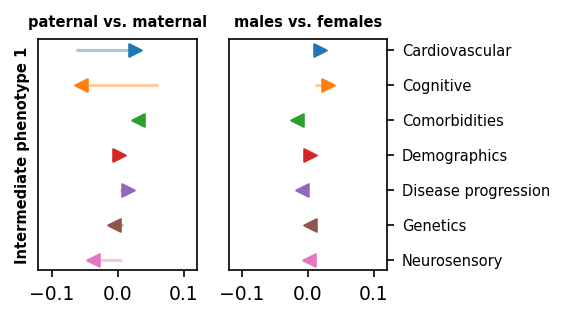

['cardiovascular', 'cognitive', 'comorbidities', 'demographics', 'disease_progression', 'genetics', 'neurosensory']
['cardiovascular', 'cognitive', 'comorbidities', 'demographics', 'disease_progression', 'genetics', 'neurosensory']


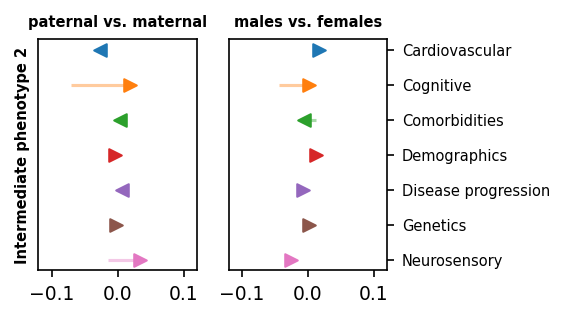

['cardiovascular', 'cognitive', 'comorbidities', 'demographics', 'disease_progression', 'genetics', 'neurosensory']
['cardiovascular', 'cognitive', 'comorbidities', 'demographics', 'disease_progression', 'genetics', 'neurosensory']


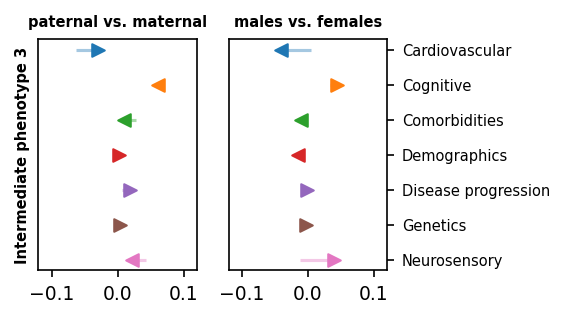

In [63]:
plt.style.use('default')
date = '25.05.13'

for c in range(0,3):
    # Compute the loading differences between maternal and paternal lineages across time points
    tmp_mat_pat = loadings_diff(loadings_mat_1, loadings_mat_2,
                                loadings_pat_1, loadings_pat_2,
                                c)
    
    # Compute the loading differences between females and males across time points
    tmp_f_m = loadings_diff(loadings_females_1, loadings_females_2,
                            loadings_males_1, loadings_males_2,
                            c)
    
    # Create a new figure with two subplots (side by side)
    fig = figure(figsize=(3, 2), dpi=150)
    # st = fig.suptitle(f"Difference over time", fontsize="large", fontweight='bold')
    # st.set_y(1.08)

    # Add subplots for the two comparisons
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    # Plot arrows
    arrows_plot(tmp_mat_pat, ax1, "paternal vs. maternal", -.12, 0.12)
    arrows_plot(tmp_f_m, ax2, "males vs. females", -.12, 0.12)

    # Adjust y-axis
    ax1.set_yticks([])
    ax1.set_ylabel(f"Intermediate phenotype {c+1}", fontsize=7, fontweight='bold')
    ax2.yaxis.tick_right()
    plt.savefig(f"{date}/IP{c+1}_time_diff.png",dpi=200,bbox_inches='tight')
    plt.show()